### Import libraries and utilities

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import pearsonr, spearmanr
from math import log
import itertools
import plotly.graph_objects as go
sns.set_theme(style="whitegrid")


In [3]:
num_feature = ['danceability', 'energy', 'loudness',
               'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration']
# lists for discretizing data
eras = [1980, 1990, 2000, 2010, 2015, 2018]
popularity = [0, 5e8]

# for converting some categorical variables
key_dict = {
    "0": "C",
    "1": "C♯",
    "2": "D",
    "3": "D♯",
    "4": "E",
    "5": "F",
    "6": "F♯",
    "7": "G",
    "8": "G♯",
    "9": "A",
    "10": "A♯",
    "11": "B"
}

mode = ["minor", "major"]


def convert_key(col):
    return col.apply(lambda x: key_dict[str(x)])


def convert_mode(col):
    return col.apply(lambda x: mode[x])


def convert_time_sig(col):
    return col.apply(lambda x: "{}/4".format(x))


def convert_duration(col):
    return col.apply(lambda x: sum(mul * int(x) for mul, x in zip([60, 1], x.split(":"))))


def convert_data(df):
    copy = df.copy()
    copy['key'] = convert_key(copy['key'])
    copy['mode'] = convert_mode(copy['mode'])
    copy['time_signature'] = convert_time_sig(copy['time_signature'])
    copy['duration'] = convert_duration(copy['duration'])
    copy["sp_release_date"] = pd.to_datetime(
        copy['sp_release_date'], format='%Y-%m-%d')
    return copy


def filter_p_value(x, threshold=0.05):
    if x < threshold:
        return 0
    else:
        return 1


def get_corr_matrix(df, feature, p=False):
    pearson_view = {}
    pp_view = {}
    pearson_playcount = {}
    pp_playcount = {}
    spearman_view = {}
    sp_view = {}
    spearman_playcount = {}
    sp_playcount = {}

    for col in feature:
        pearson_playcount[col], pp_playcount[col] = pearsonr(
            df['playcount'], df[col])
        pearson_view[col], pp_view[col] = pearsonr(df['view'], df[col])
        spearman_view[col], sp_view[col] = spearmanr(df['view'], df[col])
        spearman_playcount[col], sp_playcount[col] = spearmanr(
            df['playcount'], df[col])

    corr = pd.DataFrame(columns=feature)
    corr = corr.append(pearson_playcount, ignore_index=True)
    corr = corr.append(pearson_view, ignore_index=True)
    corr = corr.append(spearman_playcount, ignore_index=True)
    corr = corr.append(spearman_view, ignore_index=True)
    corr['type'] = ['pearson_playcount', 'pearson_view',
                    'spearman_playcount', 'spearman_view']
    corr = corr.set_index("type")

    if p:
        p_value = pd.DataFrame(columns=feature)
        p_value = p_value.append(pp_playcount, ignore_index=True)
        p_value = p_value.append(pp_view, ignore_index=True)
        p_value = p_value.append(sp_playcount, ignore_index=True)
        p_value = p_value.append(sp_view, ignore_index=True)
        return corr, pd.DataFrame(p_value).applymap(filter_p_value)

    return corr

def findsubsets(S, m):
    return set(itertools.combinations(S, m))


class ConfusionMatrix():
    def __init__(self, list):
        self.ele = list
        self.size = len(list)
        self.matrix = np.zeros((len(list), len(list)))

    def increment(self, pair):
        first_ele, second_ele = pair
        first_i = self.ele.index(first_ele)
        second_i = self.ele.index(second_ele)
        self.matrix[first_i, second_i] += 1
        self.matrix[second_i, first_i] += 1

    def update_diag(self, ele, value):
        i = self.ele.index(ele)
        self.matrix[i, i] = value

    def normalize(self):
        """
        Divide each value in the matrix (except the values on the diagonal) by the its expected value
        """
        total = np.diag(self.matrix).sum()
        for i in range(self.size):
            for j in range(i):
                self.matrix[i, j] /= self.matrix[i, i] * \
                    self.matrix[j, j] / total
                self.matrix[j, i] = self.matrix[i, j]

    def reset_diag(self):
        for i in range(self.size):
            self.matrix[i, i] = 0


def gini(df, col):
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 1 - (prob ** 2).sum()


def entropy(df, col):
    df = pd.DataFrame([1, 2, 0])
    col = 0
    counts = df[col].value_counts()
    prob = counts / counts.sum()
    return 0 - (prob * prob.apply(log)).sum()


def plot_popularity_by_year(data, **kwargs):
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    popularity_by_year = df_year.groupby("year")[["playcount", "view"]].mean()
    # years with no song will have mean view and playcount of 0
    # also convert everything to float since map_dataframe wants that for some reason
    popularity_by_year.index = popularity_by_year.index.astype('float64')
    all_year = set(popularity_by_year.index)
    earliest = min(all_year)
    latest = max(all_year)
    for year in range(int(earliest)+1, int(latest)):
        year = float(year)
        if year not in all_year:
            popularity_by_year = popularity_by_year.append(pd.DataFrame(
                [[0, 0]], columns=popularity_by_year.columns, index=[year]))
    sns.lineplot(data=popularity_by_year)


def plot_popularity_by_eras(data, **kwargs):
    df_year = data.copy()
    df_year['year'] = df['sp_release_date'].dt.year
    eras_mean = discretize(data=df_year, col='year', value_range=eras, inf='both').groupby(
        'year')[['playcount', 'view']].mean()
    ax = plt.gca()
    ax.set_xticks([i for i in range(len(eras_mean))], [
                  "<1980", "1980s", "1990s", "2000s", "2010-2014", "2015-2017", "2018-now"])
    sns.lineplot(data=eras_mean.reset_index(drop=True))


def build_interval(value_range, inf):
    assert inf in ['left', 'right', 'both', 'neither']
    intervals = []
    for i, ele in enumerate(value_range):
        if i == len(value_range) - 1:
            if inf == 'right' or inf == 'both':
                intervals.append((ele, np.inf))
        elif i == 0:
            if inf == 'left' or inf == 'both':
                intervals.append((-np.inf, ele))
            intervals.append((ele, value_range[i+1]))
        else:
            intervals.append((ele, value_range[i+1]))
    return pd.IntervalIndex.from_tuples(intervals)


def discretize(data, col, value_range, inf='right', return_interval=False):
    intervals = build_interval(value_range, inf)
    df_copy = data.copy()
    df_copy[col] = pd.cut(df_copy[col], intervals).cat.rename_categories(
        [i for i in range(len(intervals))])
    if return_interval:
        return df_copy, intervals
    return df_copy


def get_cooccurence(col1, col2, val1, val2, df):
    return ((df[col1] == val1) & (df[col2] == val2)).sum() 
    

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4e7
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
            fontsize=8
        )

### Import data

In [4]:
df_raw = pd.read_csv("data_no_genre.csv")
df_with_genre_raw = pd.read_csv("data_with_genre.csv")
df = convert_data(df_raw)
df_with_genre = convert_data(df_with_genre_raw)
print(df.columns)
print(len(df_with_genre))
df.head(2)


Index(['track', 'track_id', 'artist', 'album', 'sp_release_date', 'duration',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'playcount', 'video_id', 'view', 'channelTitle',
       'yt_release_date', 'title'],
      dtype='object')
6074


track                track_id      artist            album  \
0     Shape of You  0FE9t6xYkqWXU2ahLh6D8X  Ed Sheeran     Shape of You   
1  Blinding Lights  0sf12qNH5qcw8qpgymFOqD  The Weeknd  Blinding Lights   

  sp_release_date  duration  explicit  danceability  energy key  ...  \
0      2017-01-06       234         0         0.825   0.652  C♯  ...   
1      2019-11-29       202         0         0.513   0.796  C♯  ...   

   liveness valence    tempo  time_signature   playcount     video_id  \
0    0.0931   0.931   95.977             4/4  2971854102  JGwWNGJdvx8   
1    0.0938   0.345  171.017             4/4  2636804603  fHI8X4OXluQ   

         view   channelTitle       yt_release_date  \
0  5533840092     Ed Sheeran  2017-01-30T10:57:50Z   
1   611764719  TheWeekndVEVO  2019-11-29T05:00:08Z   

                                              title  
0  Ed Sheeran - Shape of You (Official Music Video)  
1     The Weeknd - Blinding Lights (Official Audio)  

[2 rows x 24 columns]

### Correlation between each numeric variable and playcount, view

#### For the whole dataset

<AxesSubplot:ylabel='type'>

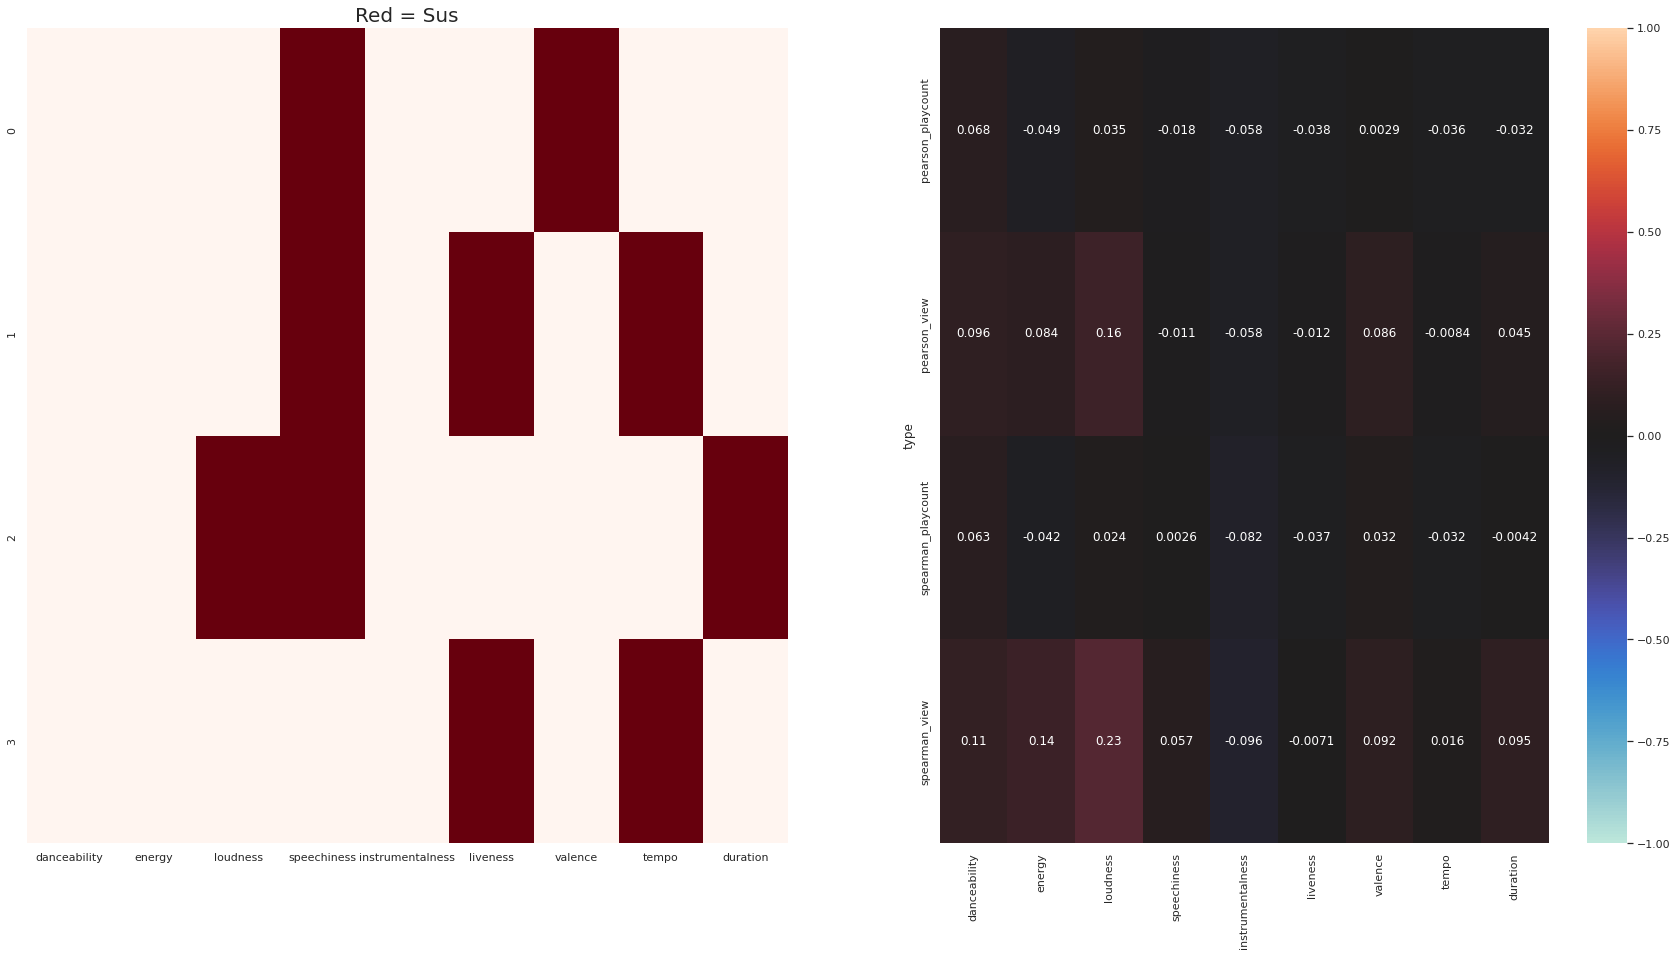

<Figure size 1440x1080 with 0 Axes>

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
corr, p = get_corr_matrix(df, num_feature, p=True)
sns.heatmap(p, cmap="Reds", ax=ax[0], cbar=False)
ax[0].set_title("Red = Sus", fontsize=20)
plt.figure(figsize=(20, 15))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, center=0, ax=ax[1])

#### For each genre

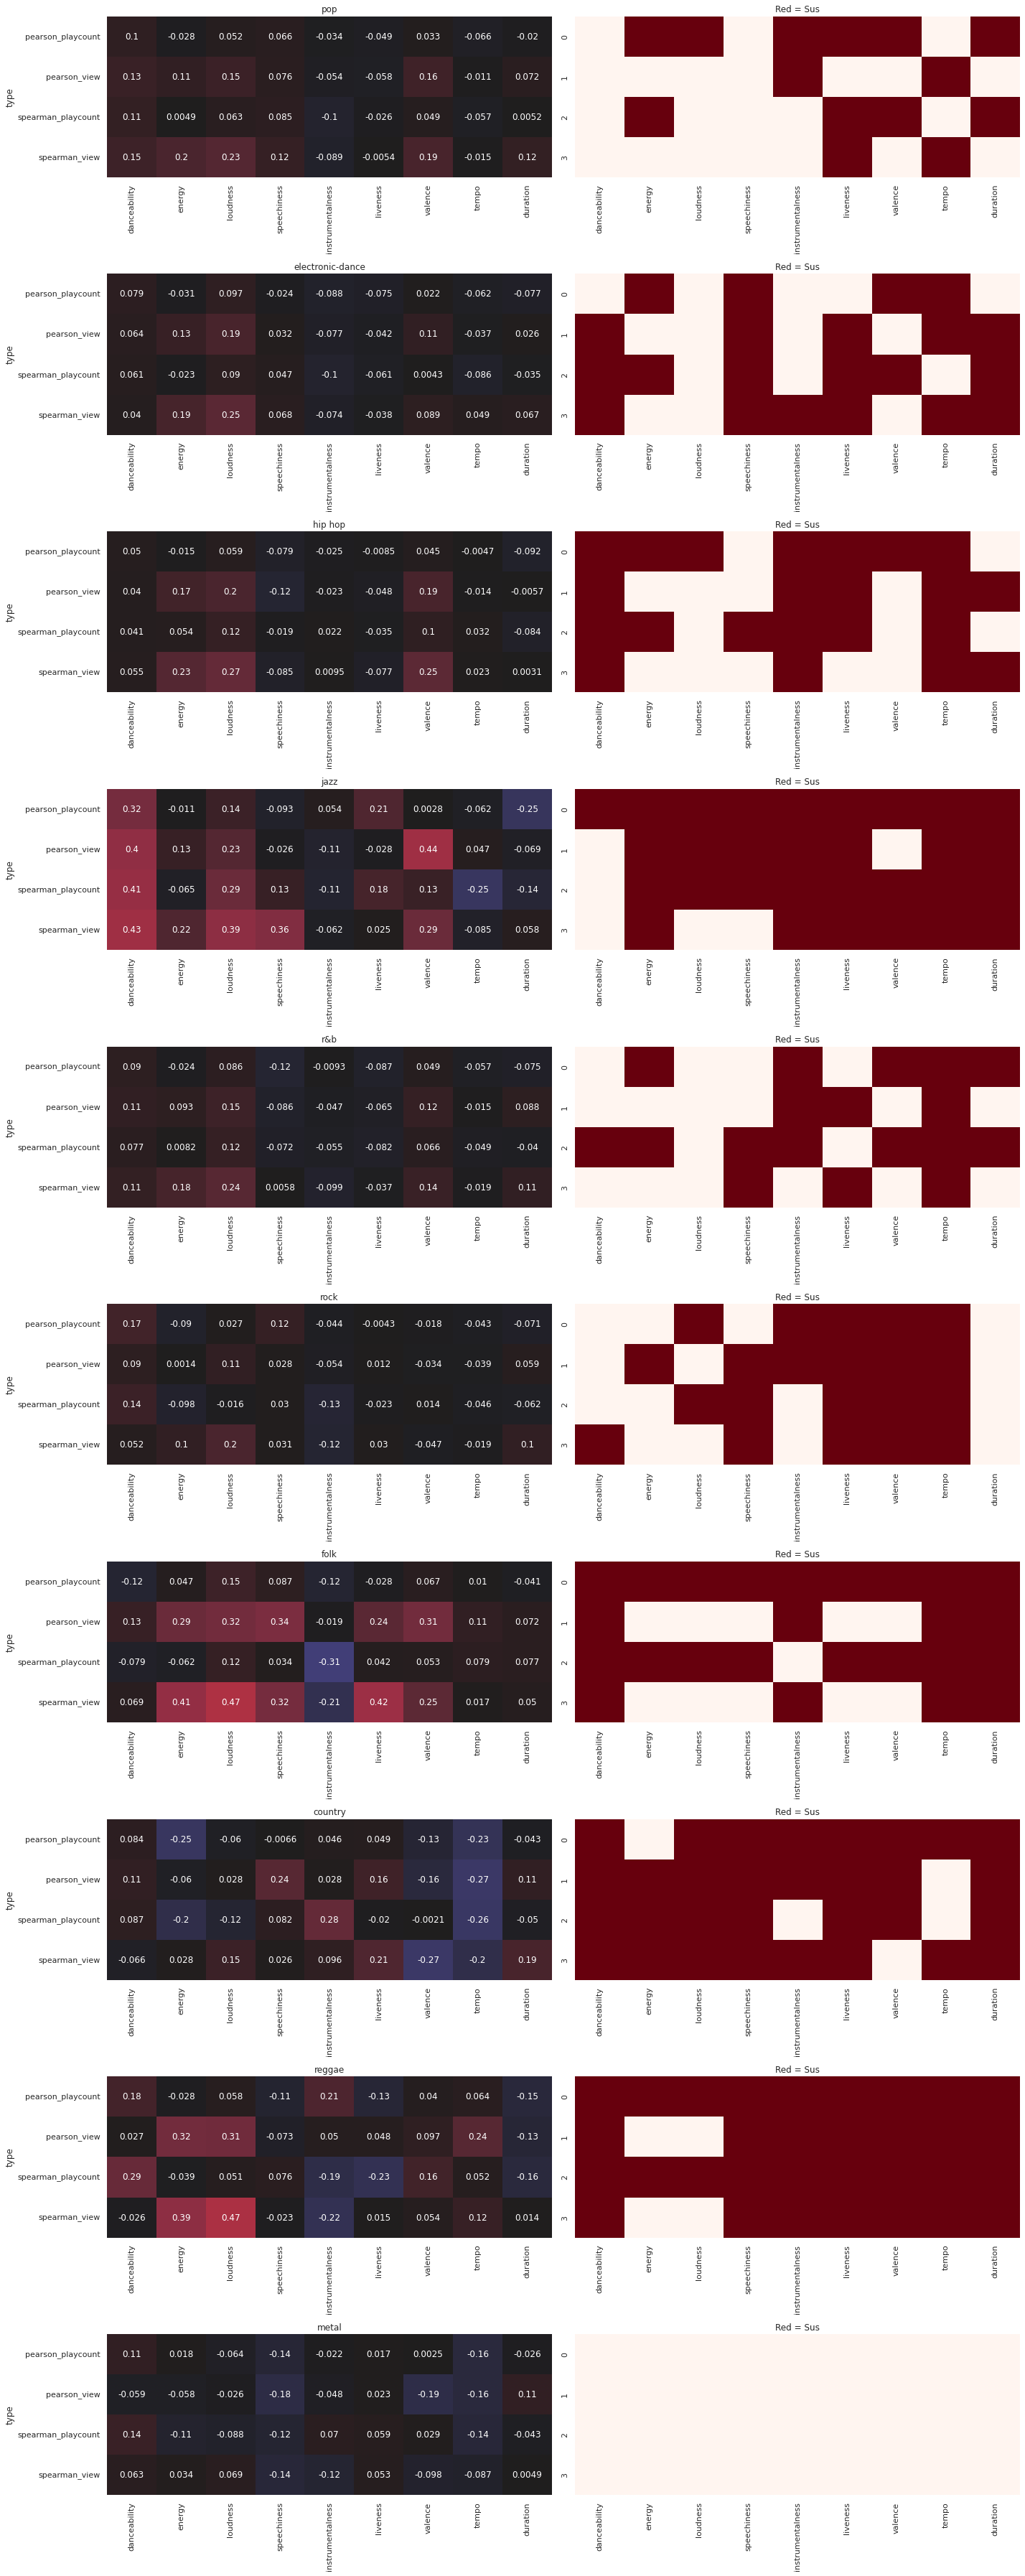

In [6]:
genres = df_with_genre["genres"].dropna().unique()
f, ax = plt.subplots(10, 2, figsize=(20, 50))
for i, genre in enumerate(genres):
    # col = i % 2
    # row = (i // 2) % 5
    corr, p = get_corr_matrix(
        df_with_genre[df_with_genre["genres"] == genre], num_feature, p=True)
    sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                ax=ax[i, 0], cbar=False, annot=True, label=genre)
    ax[i, 0].set_title(genre)
    sns.heatmap(p, cbar=False, ax=ax[i, 1], cmap="Reds")
    ax[i, 1].set_title("Red = Sus")
f.tight_layout()


### Plot distributrion and basic statistics

In [7]:
stat_dict = {}
for f in num_feature:
    stat_dict[f] = {}

for f in num_feature:
    # print(mean)
    variance = df[f].var(axis=0)
    stat_dict[f]['variance'] = variance
    # print(variance)
    skewness = df[f].skew(axis=0)
    stat_dict[f]['skewness'] = skewness
    # print(skewness)
    kurtosis = df[f].kurt(axis=0)
    stat_dict[f]['kurtosis'] = kurtosis

    # print(kurtosis)

stat_dict

{'danceability': {'variance': 0.023113392891838645,
  'skewness': -0.4233375580490291,
  'kurtosis': -0.20396023088955273},
 'energy': {'variance': 0.0325383876101898,
  'skewness': -0.5908683972187186,
  'kurtosis': -0.005525502208258093},
 'loudness': {'variance': 7.5643017122313205,
  'skewness': -1.6101905350868138,
  'kurtosis': 5.374062888970147},
 'speechiness': {'variance': 0.009346043070504859,
  'skewness': 2.130733768494755,
  'kurtosis': 5.106643404895816},
 'instrumentalness': {'variance': 0.010553225950586166,
  'skewness': 6.425631549512458,
  'kurtosis': 43.63857584972231},
 'liveness': {'variance': 0.019719357249122296,
  'skewness': 2.2083615719304905,
  'kurtosis': 5.89254970588794},
 'valence': {'variance': 0.05271051485736964,
  'skewness': 0.05815048714821434,
  'kurtosis': -0.9025734532303678},
 'tempo': {'variance': 813.6382404148376,
  'skewness': 0.4669255686244649,
  'kurtosis': -0.3161975764598237},
 'duration': {'variance': 2718.626053821716,
  'skewness': 

Text(0.5, 0.98, 'Playcounts distribution on Youtube and Spotify')

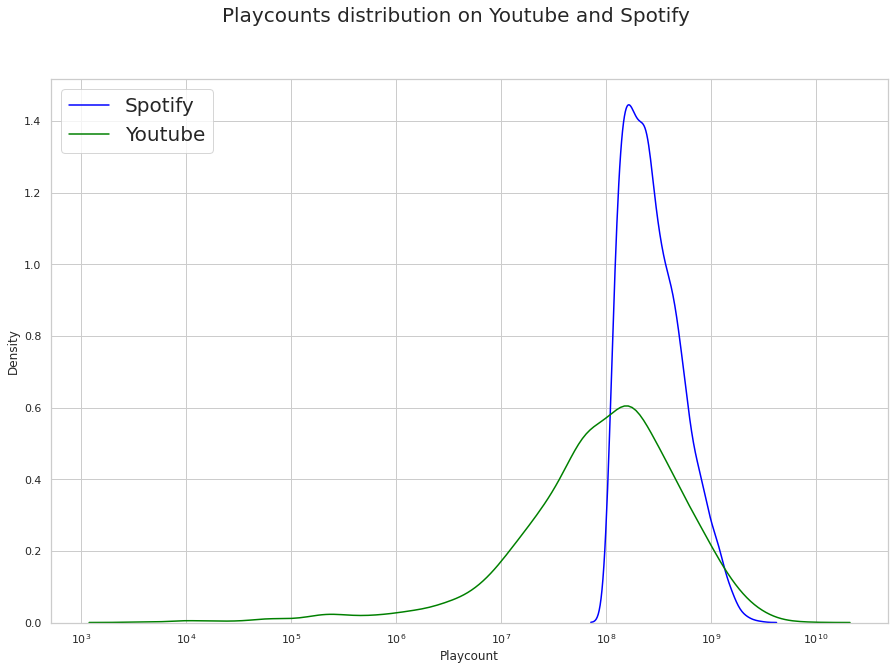

In [59]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.kdeplot(data=df, x="playcount", log_scale=True, ax=ax, color='blue', label="Spotify")
sns.kdeplot(data=df, x="view", log_scale=True, ax=ax, color='green', label="Youtube")
plt.legend(loc="upper left", prop={'size': 20})
ax.set_xlabel("Playcount")
fig.suptitle("Playcounts distribution on Youtube and Spotify", fontsize=20)

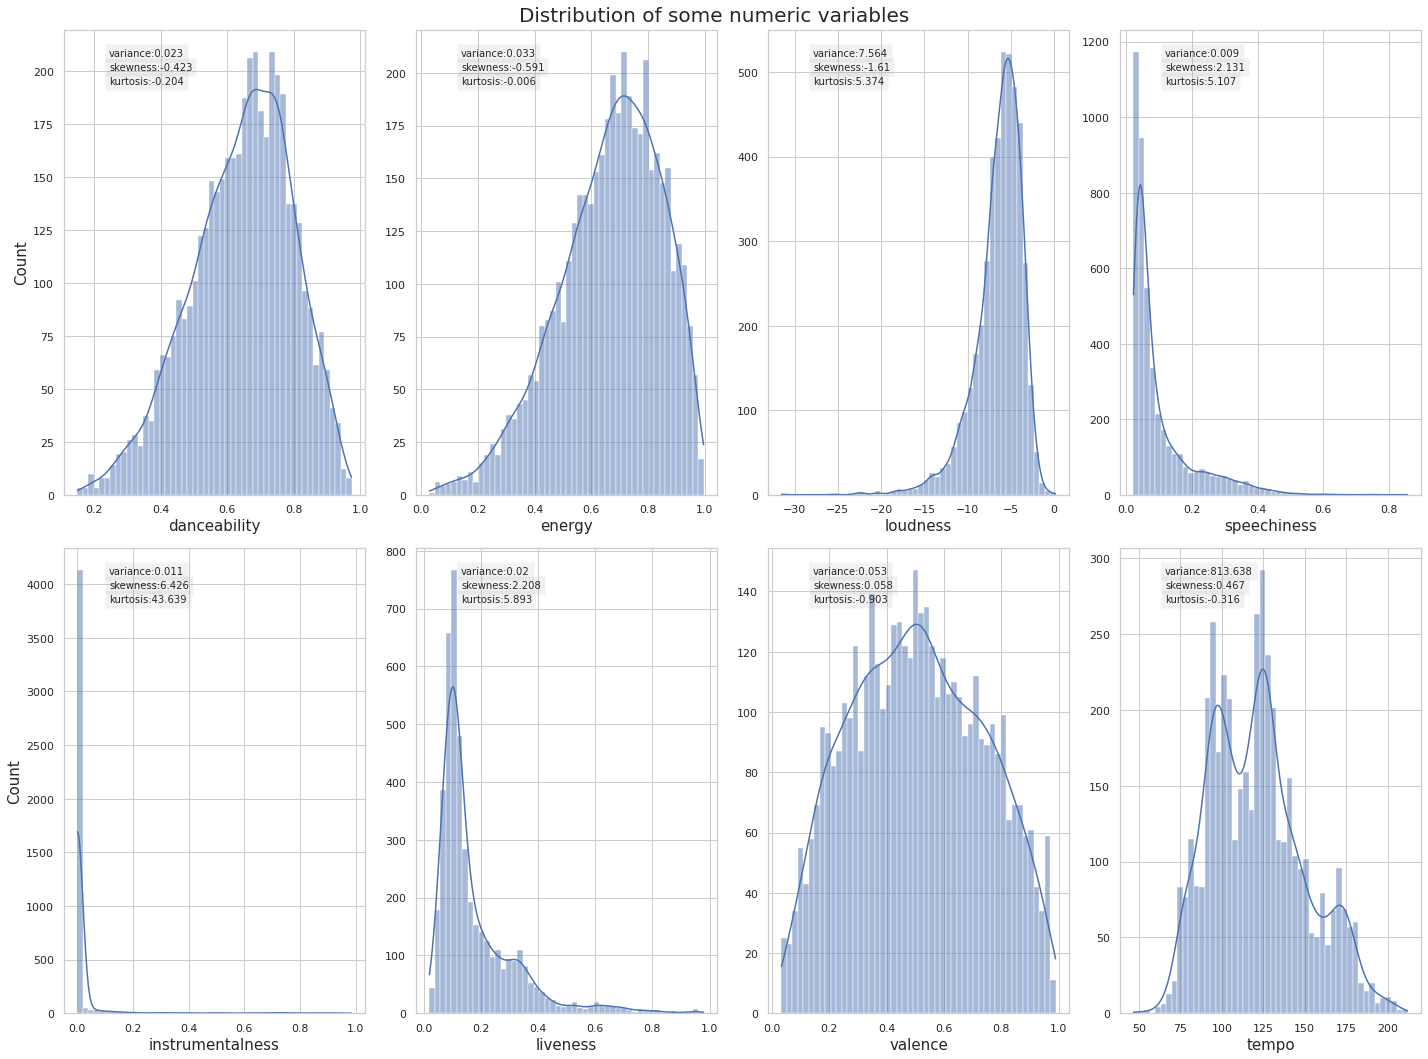

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for i in range(len(num_feature)):
    log_scale = False
    if num_feature[i] == "duration":
        continue
    # elif num_feature[i] == "instrumentalness":
    #     log_scale = True
    if i < 4:
        row = 0
    else:
        row = 1
    col = i % 4
    for j, key in enumerate(stat_dict[num_feature[i]].keys()):
        ax[row, col].text(0.15, 0.95 - j * 0.03, '{}:{}'.format(key, round(stat_dict[num_feature[i]][key], 3)), size=10,
                          verticalalignment='center', transform=ax[row, col].transAxes, bbox=dict(facecolor='grey', alpha=0.1))
    sns.histplot(data=df, x=num_feature[i], ax=ax[row, col], kde=True, bins=50, log_scale=log_scale)
    if col == 0:
        ax[row, col].set_ylabel(ax[row, col].get_ylabel(), fontsize=15)
    else:
        ax[row, col].set_ylabel("")
    ax[row, col].set_xlabel(ax[row, col].get_xlabel(), fontsize=15)
fig.suptitle("Distribution of some numeric variables", fontsize=20)
fig.tight_layout()


#### Duration distribution

Text(0.5, 0.98, 'Histogram of duration')

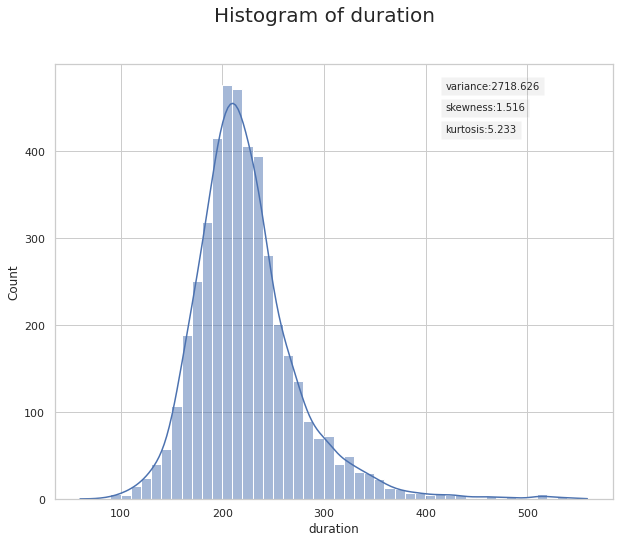

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x="duration", kde=True, bins=50, ax=ax)
for j, key in enumerate(stat_dict["duration"].keys()):
    ax.text(0.7, 0.95 - j * 0.05, '{}:{}'.format(key, round(stat_dict["duration"][key], 3)), size=10,
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='grey', alpha=0.1))
fig.suptitle("Histogram of duration", fontsize=20)

### Correlation between playcount and view

In [16]:
print("Spearman: {:.2f}".format(df['playcount'].corr(df['view'], method='spearman')))
print("Pearson: {:.2f}".format(df['playcount'].corr(df['view'], method='pearson')))

Spearman: 0.55
Pearson: 0.59


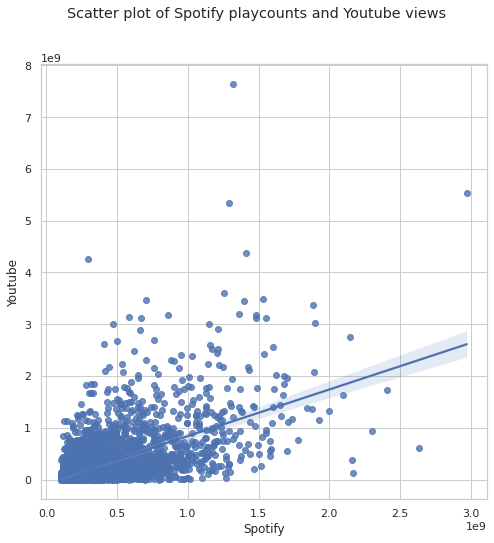

In [23]:
f, ax = plt.subplots(figsize=(8, 8))
sns.regplot(data=df, x="playcount", y="view", ax=ax)
ax.set_xlabel("Spotify")
ax.set_ylabel("Youtube")
f.suptitle("Scatter plot of Spotify playcounts and Youtube views")
plt.show()

### Counts of each mode with different playcount bins

#### Shitty population pyramid

In [29]:
bins = pd.IntervalIndex.from_tuples(
    [(0, 2e8), (2e8, 3e8), (3e8, 4e8), (4e8, 5e8), (5e8, 7.5e8), (7.5e8, 1e9), (1e9, 3e9)])
df_pyra = df.copy()
df_pyra["bins"] = pd.cut(df_pyra["playcount"], bins)

In [30]:
pop_dist_0 = df_pyra[df_pyra["mode"] == "minor"].groupby("bins")[["playcount"]].count()
pop_dist_1 = df_pyra[df_pyra["mode"] == "major"].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["major"] = pop_dist_0['playcount']
pop_dist["minor"] = pop_dist_1['playcount'].apply(lambda x: 0 - x)
pop_dist = pop_dist.reset_index()


In [31]:
pop_dist


bins  major  minor
0            (0.0, 200000000.0]    636   -927
1    (200000000.0, 300000000.0]    394   -664
2    (300000000.0, 400000000.0]    229   -348
3    (400000000.0, 500000000.0]    158   -235
4    (500000000.0, 750000000.0]    175   -288
5   (750000000.0, 1000000000.0]     92   -124
6  (1000000000.0, 3000000000.0]     82   -108

Text(0.5, 0, 'bruh')

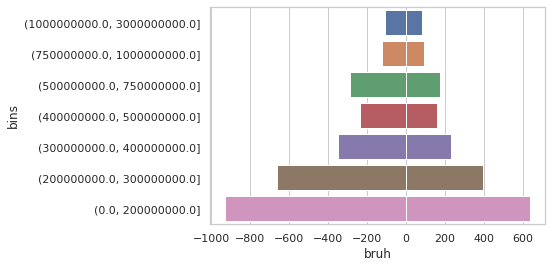

In [32]:
sns.barplot(x="major", y="bins", data=pop_dist, order=bins[::-1])
sns.barplot(x="minor", y="bins", data=pop_dist, order=bins[::-1])
plt.xlabel("bruh")


#### Epic lollipop plot

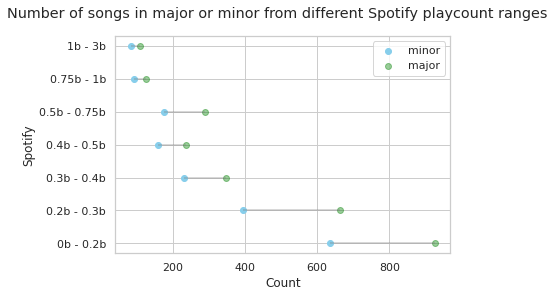

In [37]:
pop_dist_0 = df_pyra[df_pyra["mode"] == "minor"].groupby("bins")[["playcount"]].count()
pop_dist_1 = df_pyra[df_pyra["mode"] == "major"].groupby("bins")[["playcount"]].count()
pop_dist = pd.DataFrame()
pop_dist["minor"] = pop_dist_0['playcount']
pop_dist["major"] = pop_dist_1['playcount']
pop_dist = pop_dist.reset_index()
my_range = range(1, len(pop_dist.index)+1)

# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=pop_dist['minor'],
           xmax=pop_dist['major'], color='grey', alpha=0.4)
plt.scatter(pop_dist['minor'], my_range,
            color='skyblue', alpha=1, label='minor')
plt.scatter(pop_dist['major'], my_range,
            color='green', alpha=0.4, label='major')
plt.legend()

# Add title and axis names
group_name = [
    "0b - 0.2b",
    "0.2b - 0.3b",
    "0.3b - 0.4b",
    "0.4b - 0.5b",
    "0.5b - 0.75b",
    "0.75b - 1b",
    "1b - 3b"
]
plt.yticks(my_range, group_name)
plt.xlabel('Count')
plt.ylabel('Spotify')
plt.suptitle("Number of songs in major or minor from different Spotify playcount ranges")
# Show the graph
plt.show()

### Scatter plot of view and playcount corresponding to the "explicit" variable

explicit
0    3172
1    1288
Name: track_id, dtype: int64


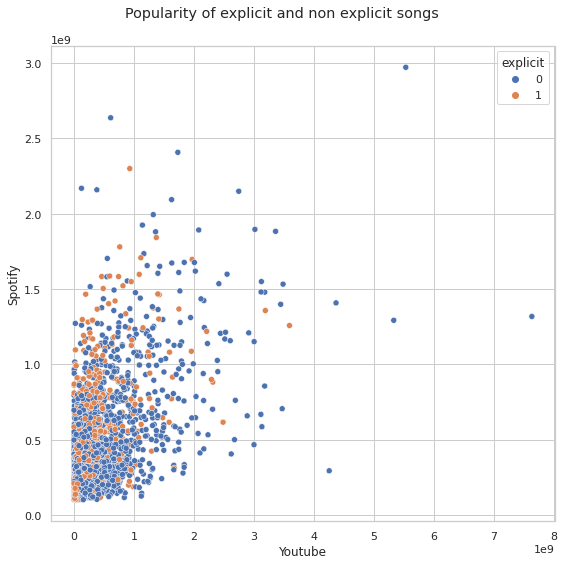

In [38]:
print(df.groupby('explicit')['track_id'].count())
f, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x="view", y="playcount", hue='explicit', ax=ax)
ax.set_ylabel("Spotify")
ax.set_xlabel("Youtube")
f.suptitle("Popularity of explicit and non explicit songs")
f.tight_layout()

### Strip plot of the playcount and view of each key

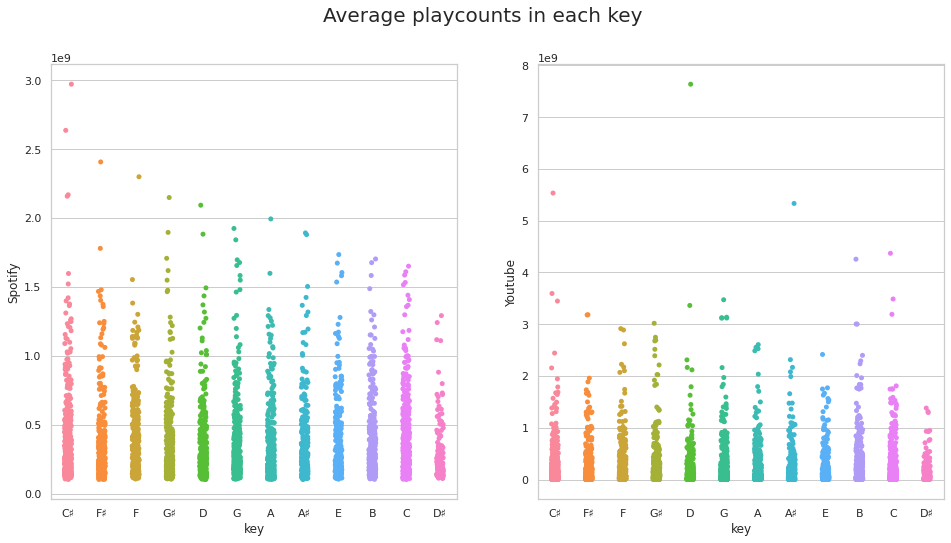

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.stripplot(x="key", y="playcount", data=df, ax=ax[0])
sns.stripplot(x="key", y="view", data=df, ax=ax[1])
ax[0].set_ylabel("Spotify")
ax[1].set_ylabel("Youtube")
fig.suptitle("Average playcounts in each key", fontsize=20)
plt.show()


### Bar plot of the counts of each categorical variable

#### Explicit

<AxesSubplot:xlabel='explicit', ylabel='count'>

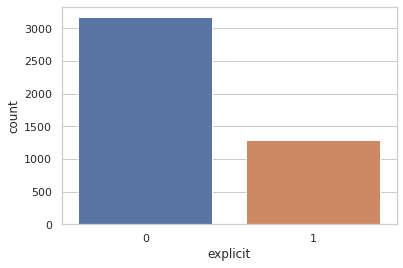

In [42]:
sns.countplot(x="explicit", data=df, order=df['explicit'].value_counts().index)


#### Key

Text(0.9, 0.91, 'Entropy=1.1')

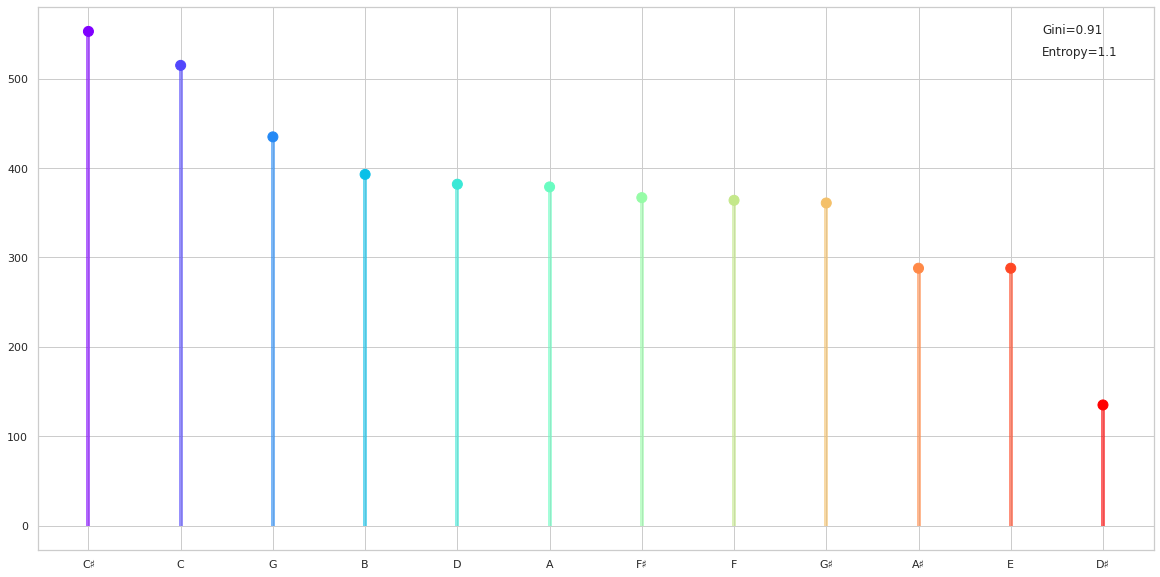

In [165]:
# sns.countplot(x="key", data=df, order=df['key'].value_counts().index)
fig, ax = plt.subplots(figsize=(20, 10))
key_count = df['key'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(key_count)))
my_range = np.arange(len(key_count))
ax.vlines(x=my_range, ymin=0, ymax=key_count - 5,
          alpha=0.6, linewidth=4, colors=colors)
ax.scatter(x=my_range, y=key_count, s=100, c=colors)
ax.set_xticks(my_range, key_count.index)
ax.text(0.9, 0.95, 'Gini={}'.format(
    round(gini(df, 'key'), 2)), transform=ax.transAxes)
ax.text(0.9, 0.91, 'Entropy={}'.format(
    round(entropy(df, 'key'), 2)), transform=ax.transAxes)


#### Time signature

<AxesSubplot:xlabel='time_signature', ylabel='count'>

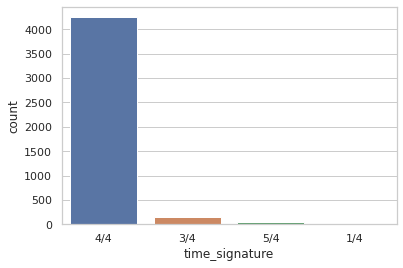

In [166]:
sns.countplot(x="time_signature", data=df,
              order=df['time_signature'].value_counts().index)


#### Mode

<AxesSubplot:xlabel='mode', ylabel='count'>

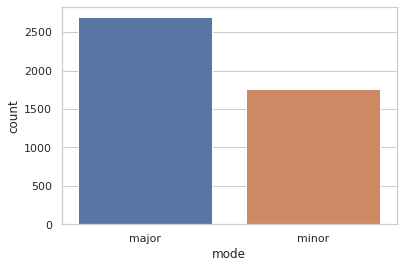

In [167]:
sns.countplot(x="mode", data=df, order=df['mode'].value_counts().index)


### Artists with the highest number of hits

<AxesSubplot:xlabel='count', ylabel='artist'>

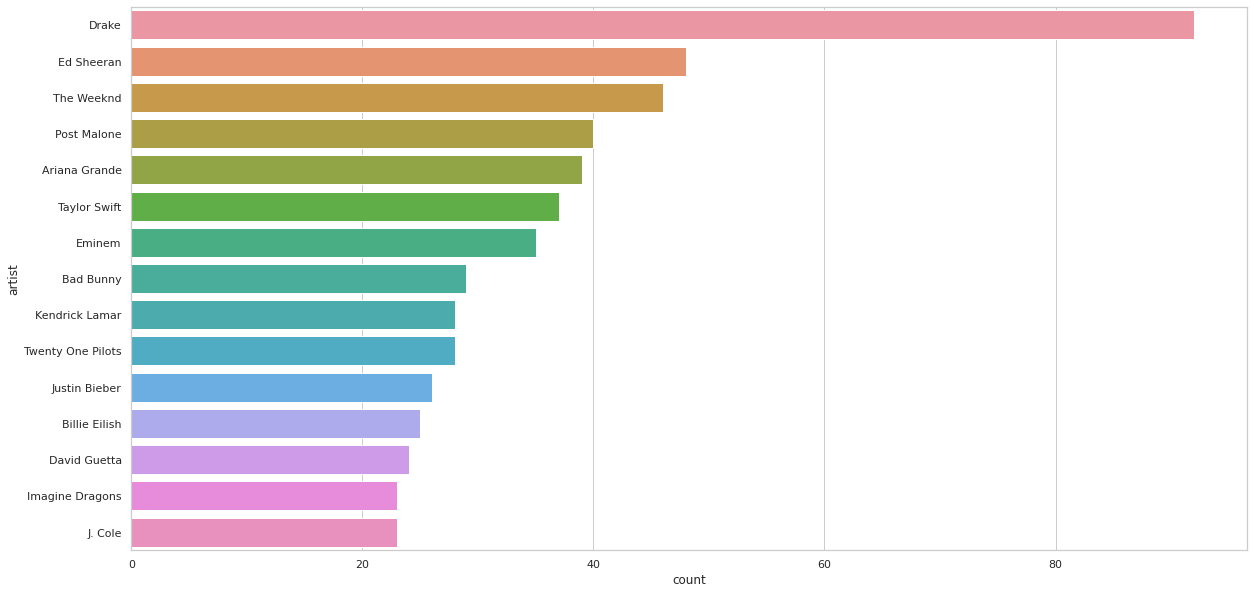

In [168]:
plt.figure(figsize=(20, 10))
df_no_various_artist = df[df["artist"] != "Various Artists"]
# artist_count = df_no_various_artist["artist"].value_counts().reset_index()
# num_artist = 15
# plt.hlines(y=range(num_artist), xmin=0, xmax=artist_count["artist"][:num_artist], color='grey', alpha=0.4)
# plt.scatter(y=range(num_artist), x=artist_count["artist"][:num_artist], s=200, alpha=0.8)
# plt.xticks(range())
sns.countplot(y="artist", data=df_no_various_artist,
              order=df_no_various_artist['artist'].value_counts().index[0:15])


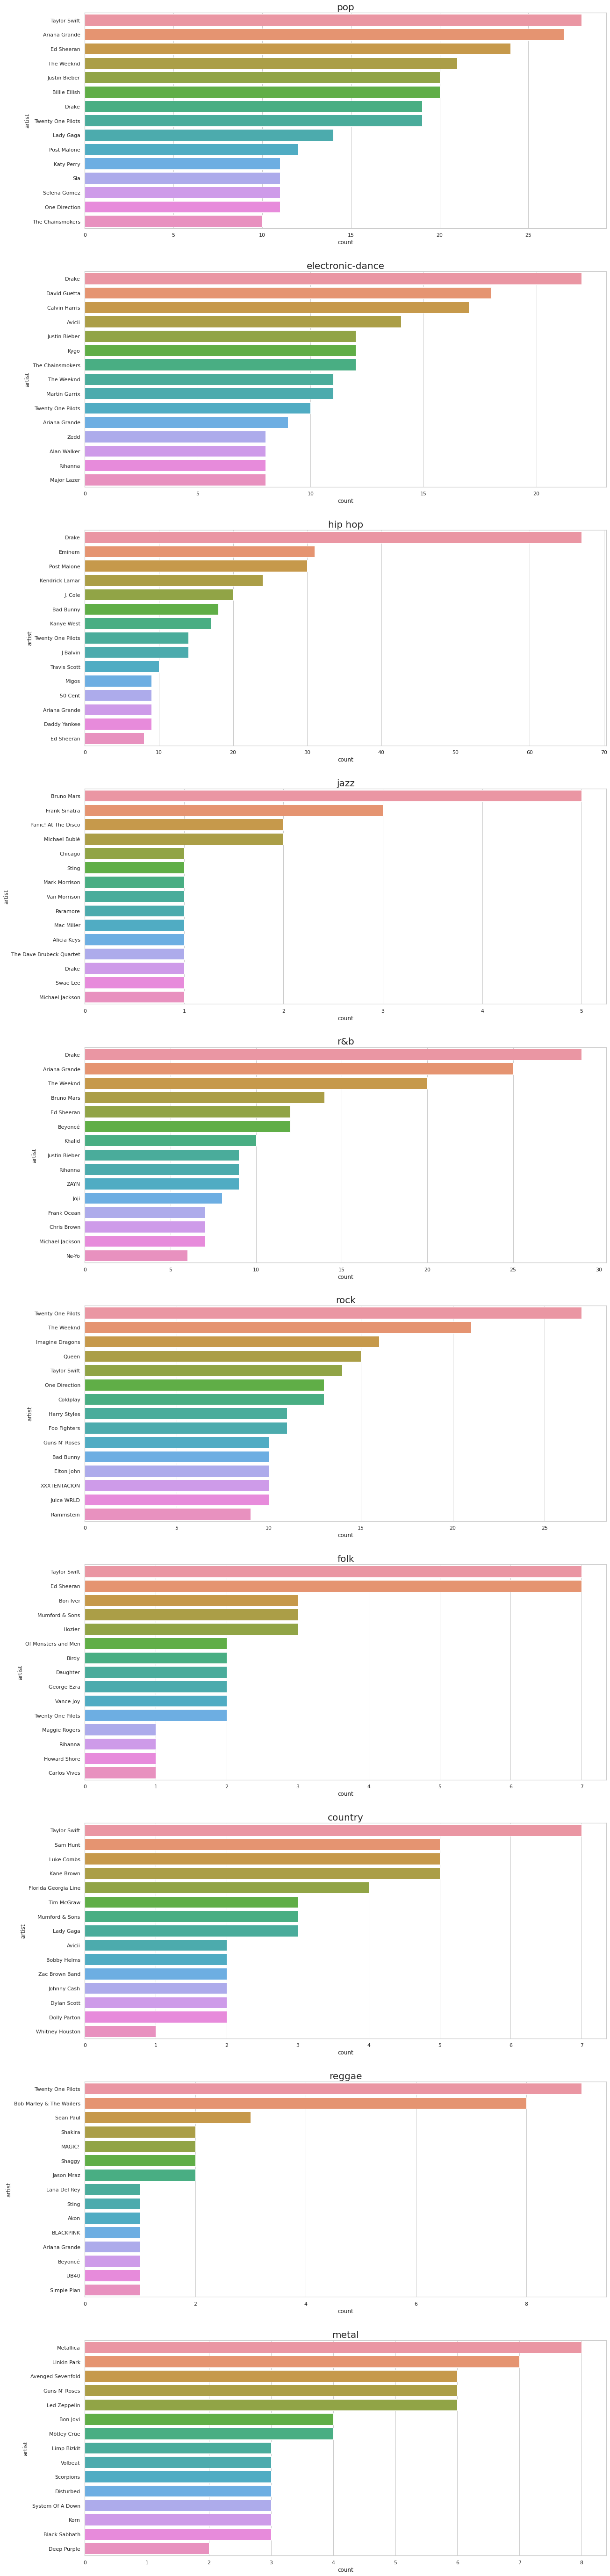

In [173]:
f, ax = plt.subplots(10, 1, figsize=(20, 100))
genres = df_with_genre["genres"].dropna().unique()
df_no_various_artist = df_with_genre[df_with_genre["artist"]
                                     != "Various Artists"]
for i, genre in enumerate(genres):
    data = df_no_various_artist[df_no_various_artist["genres"] == genre]
    sns.countplot(y="artist", data=data,
                  order=data['artist'].value_counts().index[0:15], ax=ax[i])
    ax[i].set_title(genre, fontsize=20)

#### Circular bar plot of the artists with the highest mean playcounts with respect to each genre

In [85]:
df_genre_sub = df_with_genre[['artist', 'playcount', 'genres']]
df_genre_sub.head()
cir_plot = df_genre_sub.groupby(['genres', 'artist'])[['playcount']].mean().reset_index()
cir_plot = cir_plot.set_index('artist').groupby(['genres'])['playcount'].nlargest(5).reset_index()
cir_plot.head()

genres            artist     playcount
0  country         Lady Gaga  9.713414e+08
1  country     The Lumineers  6.931471e+08
2  country  Lost Frequencies  6.578406e+08
3  country       Mark Ronson  5.079513e+08
4  country            Maluma  5.019011e+08

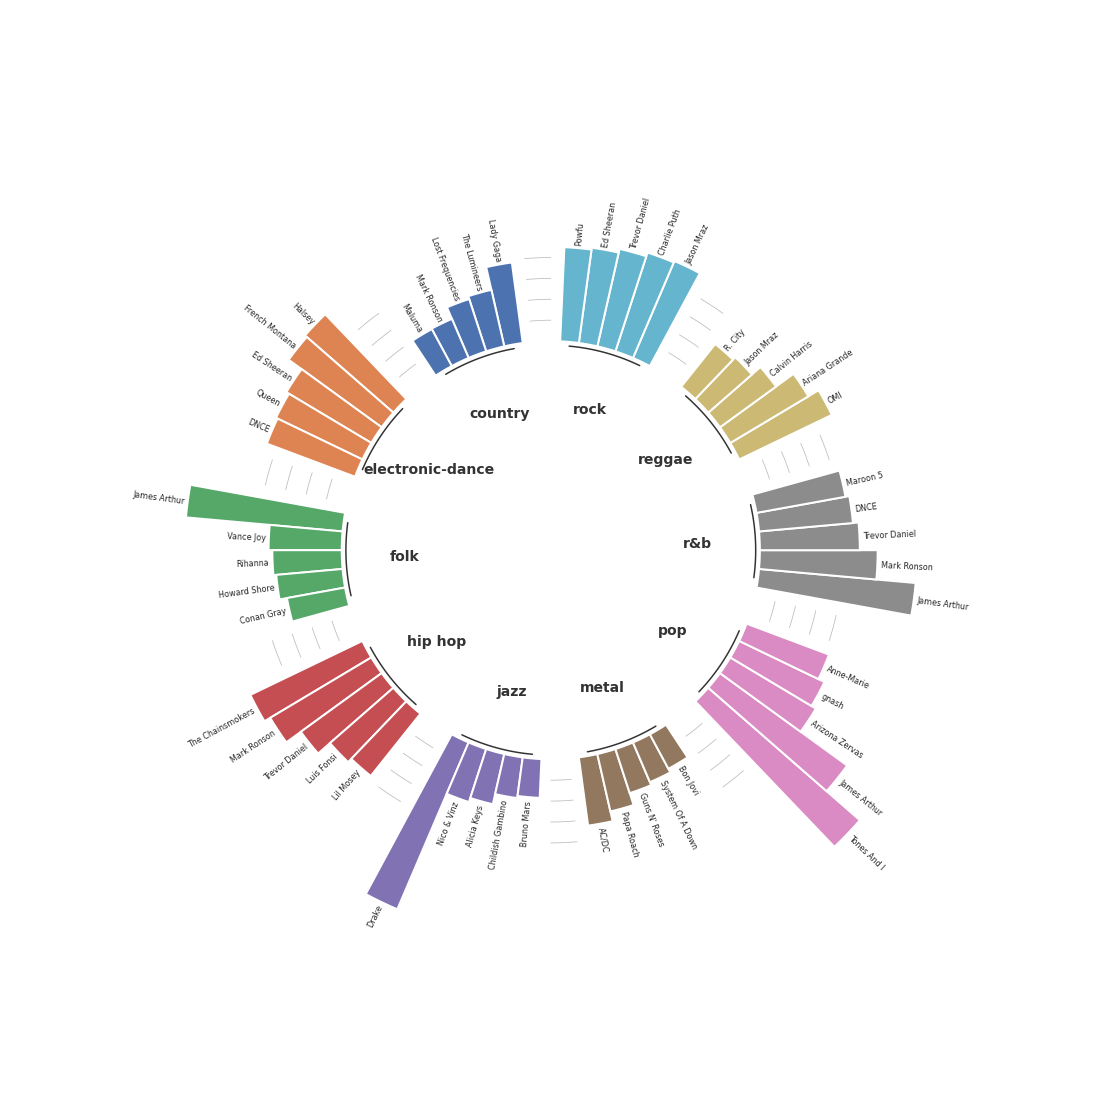

In [120]:
# Grab the group values
GROUP = cir_plot["genres"].values
VALUES = cir_plot["playcount"].values
LABELS = cir_plot["artist"].values

# Add three empty bars to the end of each group
PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

# Obtaining the right indexes is now a little more complicated
offset = 0
IDXS = []
GROUPS_SIZE = [5 for i in range(10)]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
# Same layout as above
fig, ax = plt.subplots(figsize=(40, 20), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-2.5e9, 4e9)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

# Use different colors for each group!
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# And finally add the bars. 
# Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(cir_plot["genres"].unique(), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5e7] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -7.5e8, group, color="#333333", fontsize=14, 
        fontweight="bold", ha="center", va="center"
    )
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [2.5e8] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [5e8] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [7.5e8] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [1e9] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD

### Genre

#### The count of each genre

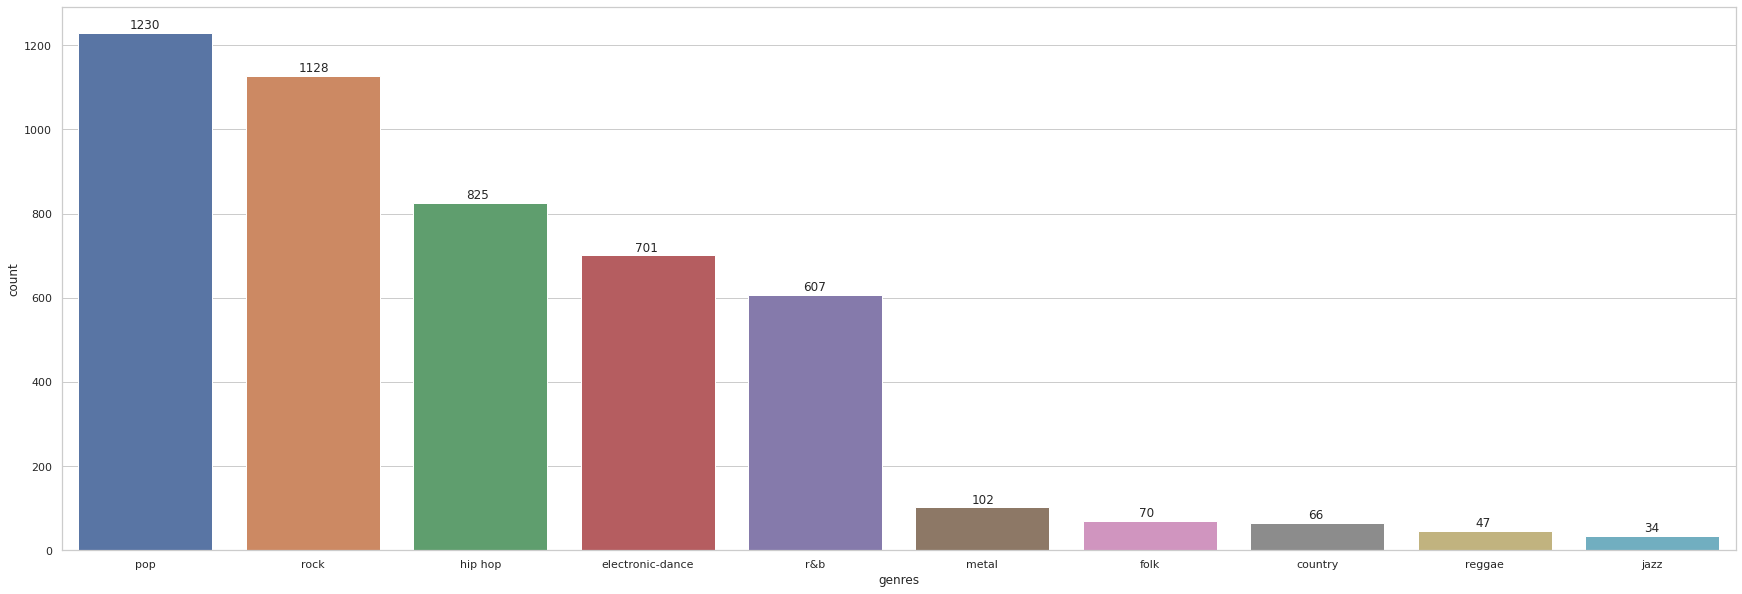

In [174]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.countplot(x="genres", data=df_with_genre,
              order=df_with_genre['genres'].value_counts(dropna=True).index, ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() *
                1.005 + 0.31, p.get_height() + 10))


#### Playcount and view distribution with respect to each genre

<AxesSubplot:xlabel='genres', ylabel='view'>

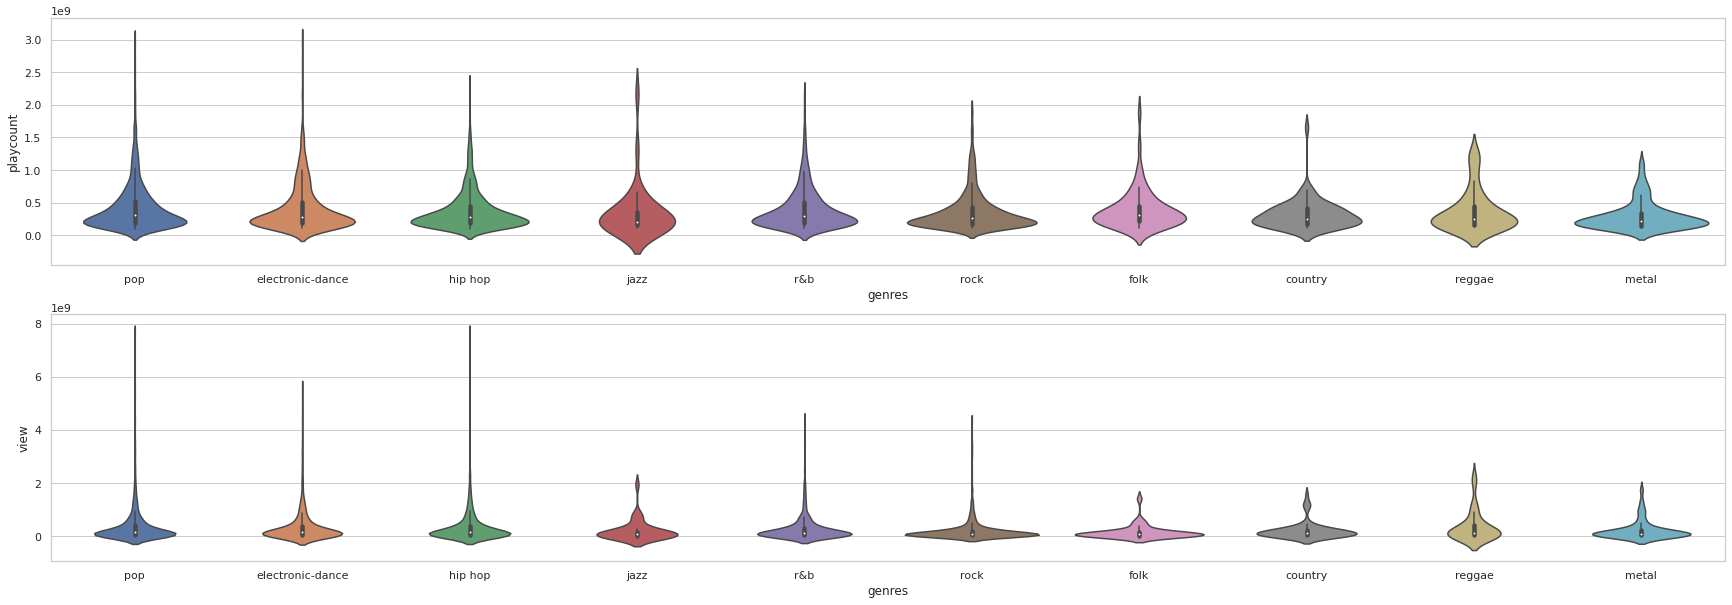

In [175]:
fig, ax = plt.subplots(2, 1, figsize=(30, 10))
sns.violinplot(x="genres", y="playcount", data=df_with_genre, ax=ax[0])
sns.violinplot(x="genres", y="view", data=df_with_genre, ax=ax[1])


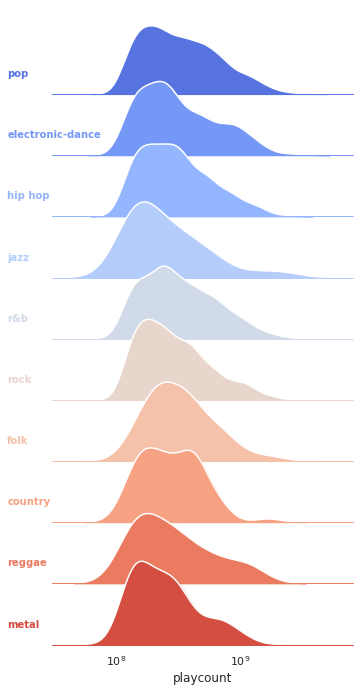

In [33]:
# cmap = cm.get_cmap('viridis')
# d = {'color': [cmap(i) for i in np.linspace(0, 1, 10)]}
pal = sns.color_palette(palette='coolwarm', n_colors=10)
ridge_plot = sns.FacetGrid(df_with_genre, row="genres", hue="genres",
                           aspect=5, height=1, palette=pal)

ridge_plot.map(sns.kdeplot, 'playcount', clip_on=False,
               shade=True, alpha=1, lw=1, log_scale=True, bw_adjust=1)
ridge_plot.map(sns.kdeplot, 'playcount', 
      bw_adjust=1, clip_on=False, 
      color="w", lw=1.5)
ridge_plot.map(plt.axhline, y=0, lw=1, clip_on=False)
for ax, genre in zip(ridge_plot.axes.flat, df_with_genre["genres"].dropna().unique()):
    ax.text(-0.15, 0.2, genre,
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color(), transform=ax.transAxes)
ridge_plot.set(yticks=[])
ridge_plot.set_ylabels("")
ridge_plot.set(title="")
ridge_plot.fig.subplots_adjust(hspace=-0.3)
ridge_plot.despine(bottom=True, left=True)
plt.show()

#### Mean views and playcounts of the explicit and non-explicit songs of each genre

<AxesSubplot:xlabel='genres', ylabel='view'>

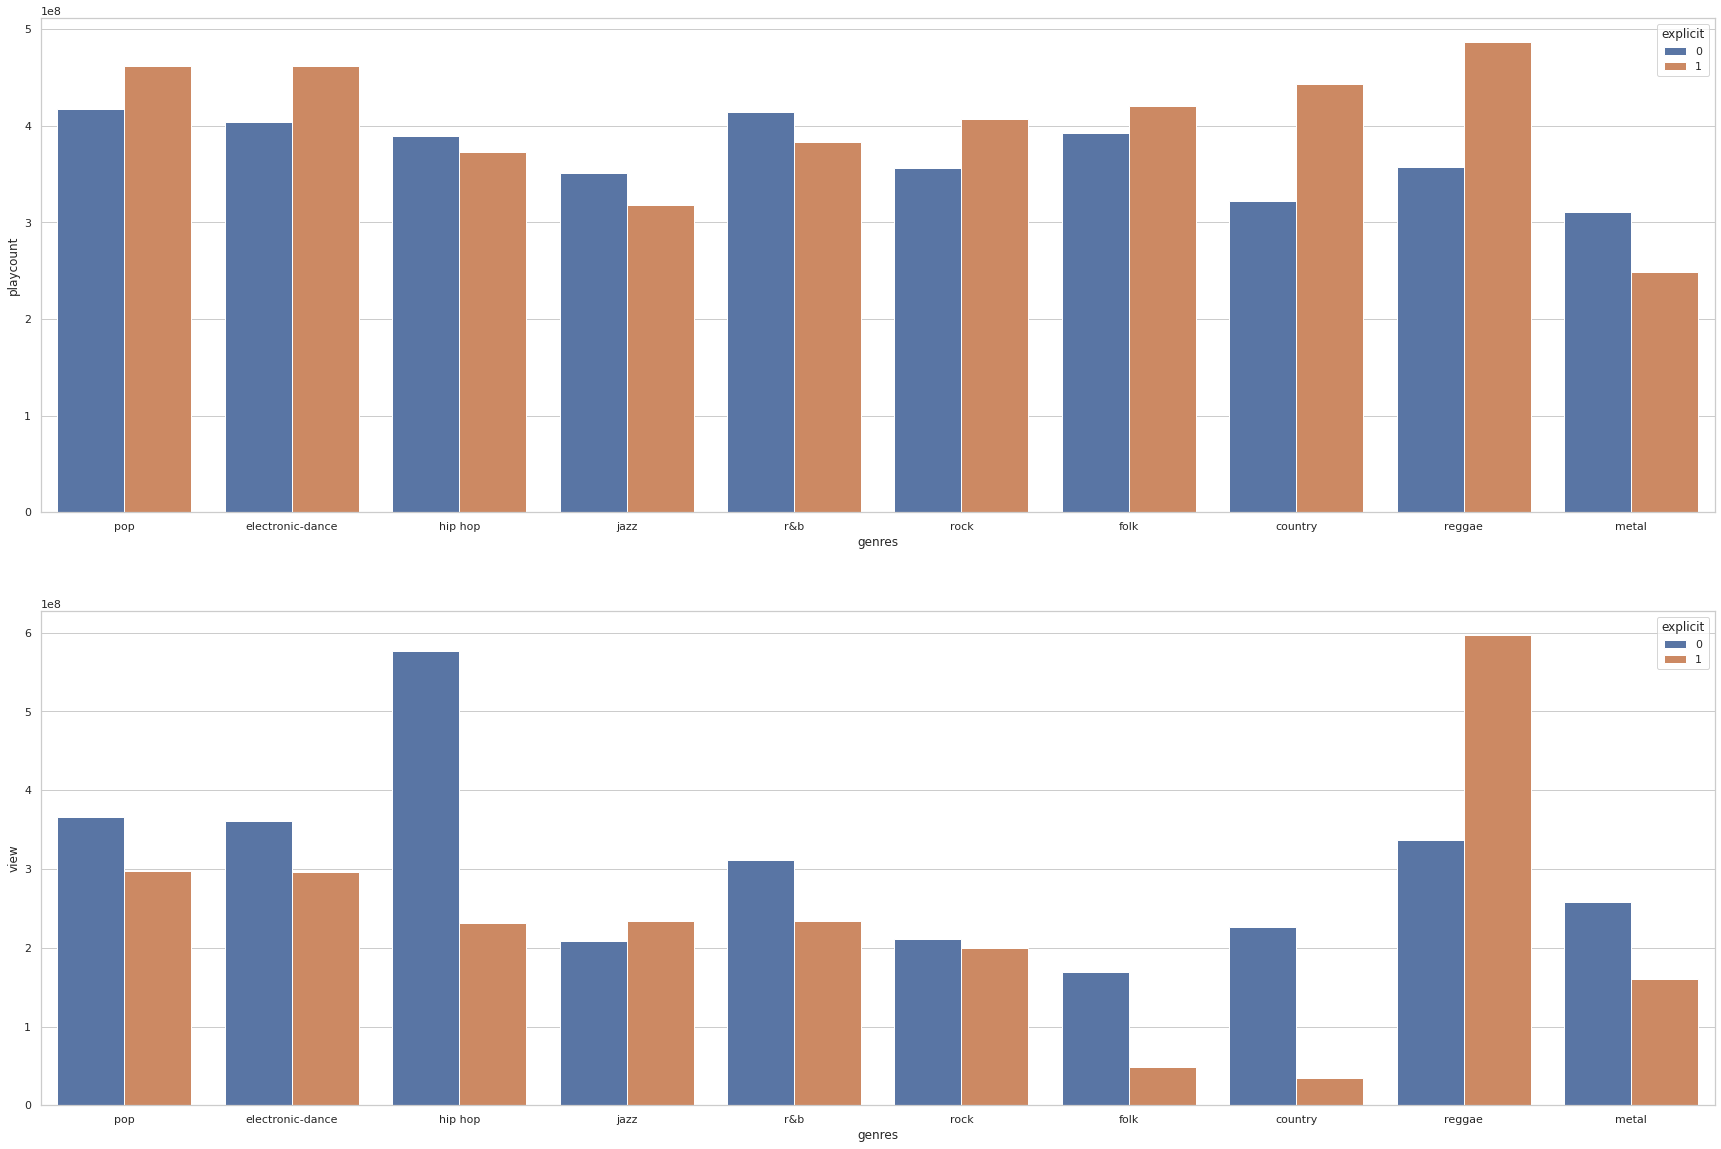

In [177]:
fig, ax = plt.subplots(2, 1, figsize=(30, 20))
sns.barplot(x="genres", y="playcount", data=df_with_genre,
            ax=ax[0], ci=None, hue="explicit")
sns.barplot(x="genres", y="view", data=df_with_genre,
            ax=ax[1], ci=None, hue="explicit")


#### Distribution of some numeric features with respect to each genre

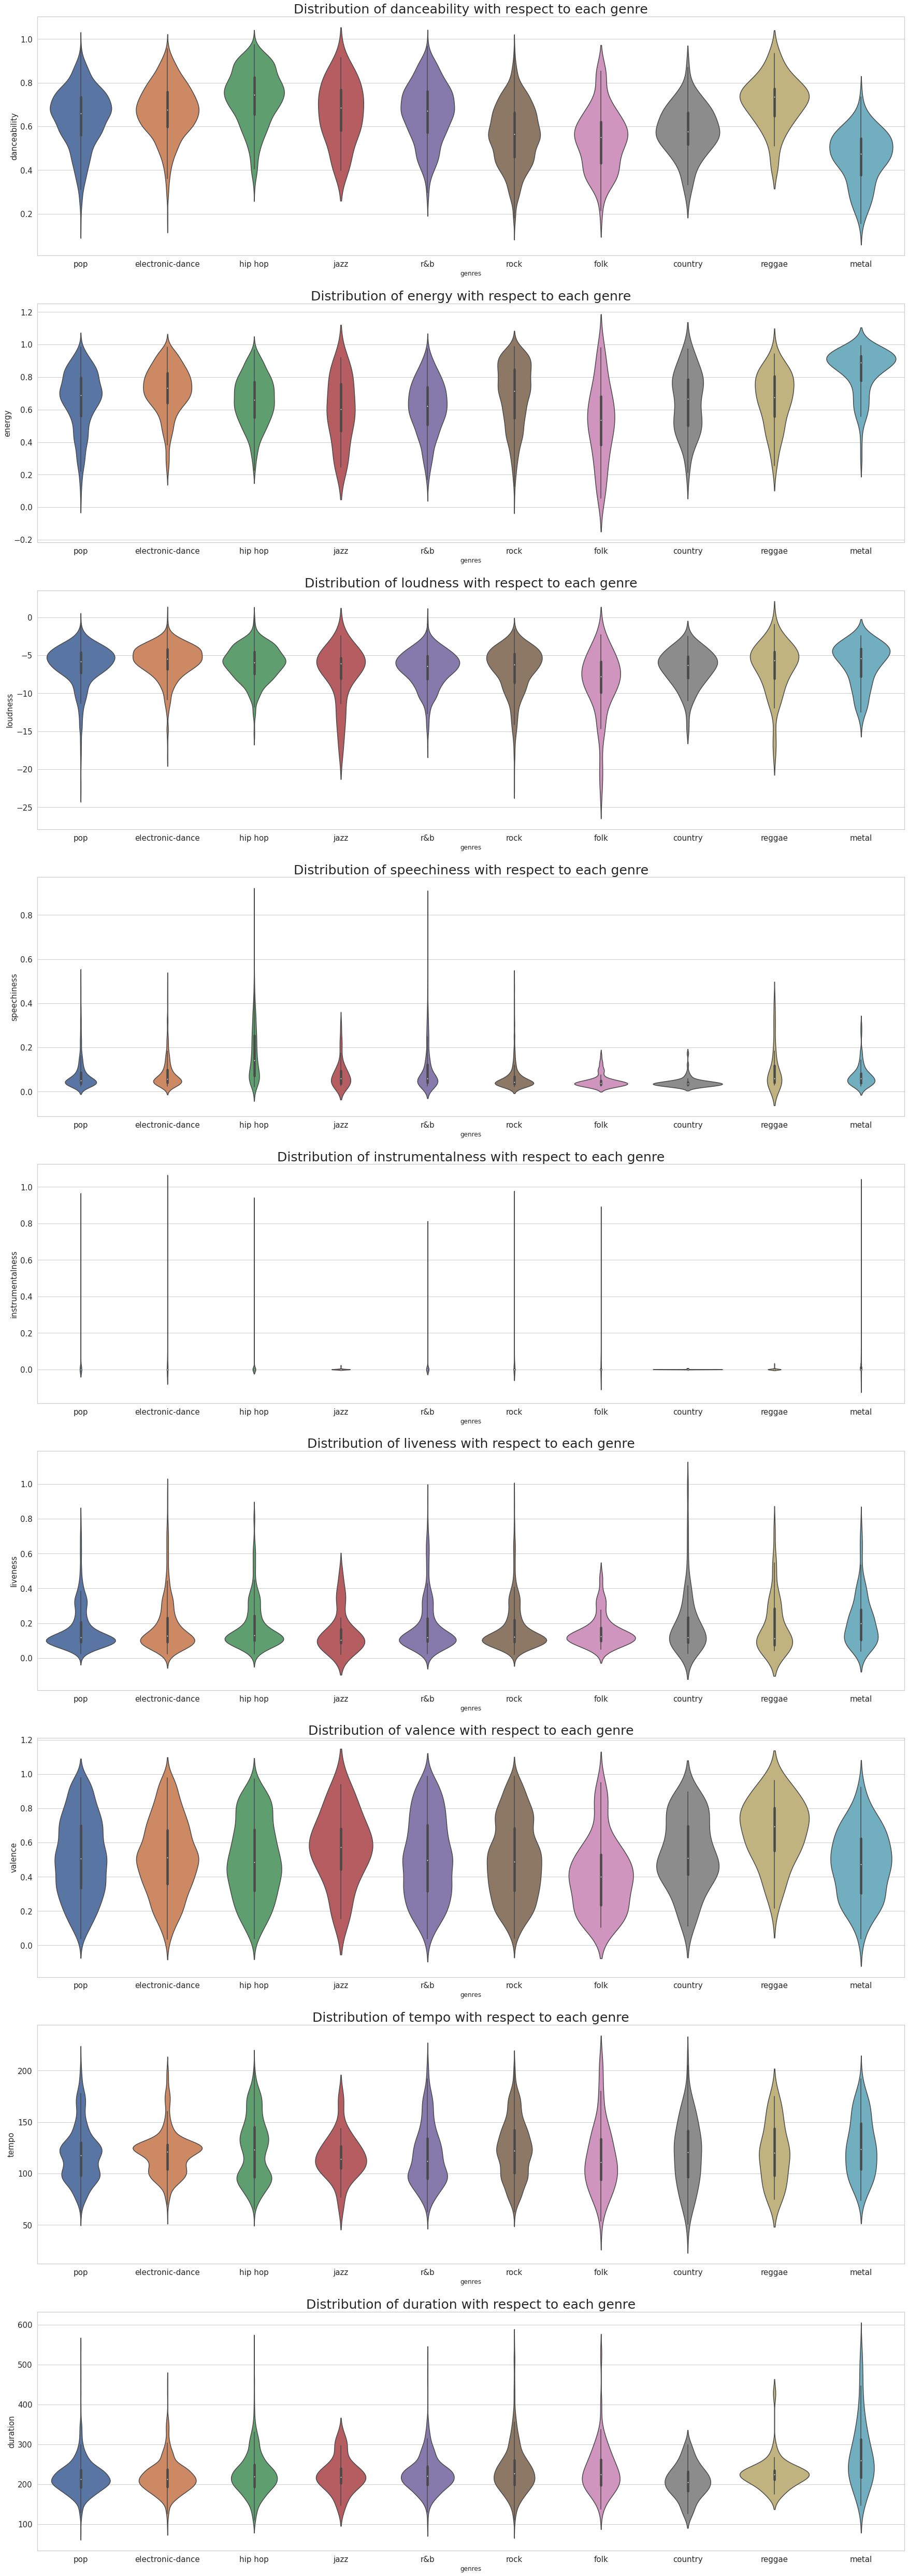

In [27]:
fig, ax = plt.subplots(len(num_feature), 1, figsize=(30, 10 * len(num_feature)))
for i in range(len(num_feature)):
    sns.violinplot(x="genres", y=num_feature[i], data=df_with_genre,  ax=ax[i])
    ax[i].set_title(f'Distribution of {num_feature[i]} with respect to each genre', fontsize=25)
    ax[i].tick_params(labelsize=15)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=15)
    ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=15)

#### Within each genre which mode is more prominent?

In [181]:
genre_mode = df_with_genre.groupby("genres")["mode"].value_counts()
genre_mode = pd.DataFrame(genre_mode).rename(
    columns={'mode': 'count'}).reset_index()
table = pd.pivot_table(genre_mode, values='count', index='mode',
                       columns=['genres'], aggfunc=np.sum)
table = table.astype(int)


def scale(series):
    return series / series.sum()


for col in table.columns:
    table[col] = scale(table[col])
table.head()


genres   country  electronic-dance      folk   hip hop      jazz     metal  \
mode                                                                         
major   0.833333          0.492154  0.857143  0.551515  0.588235  0.617647   
minor   0.166667          0.507846  0.142857  0.448485  0.411765  0.382353   

genres       pop       r&b    reggae      rock  
mode                                            
major   0.606504  0.576606  0.574468  0.679965  
minor   0.393496  0.423394  0.425532  0.320035

<AxesSubplot:xlabel='genres', ylabel='mode'>

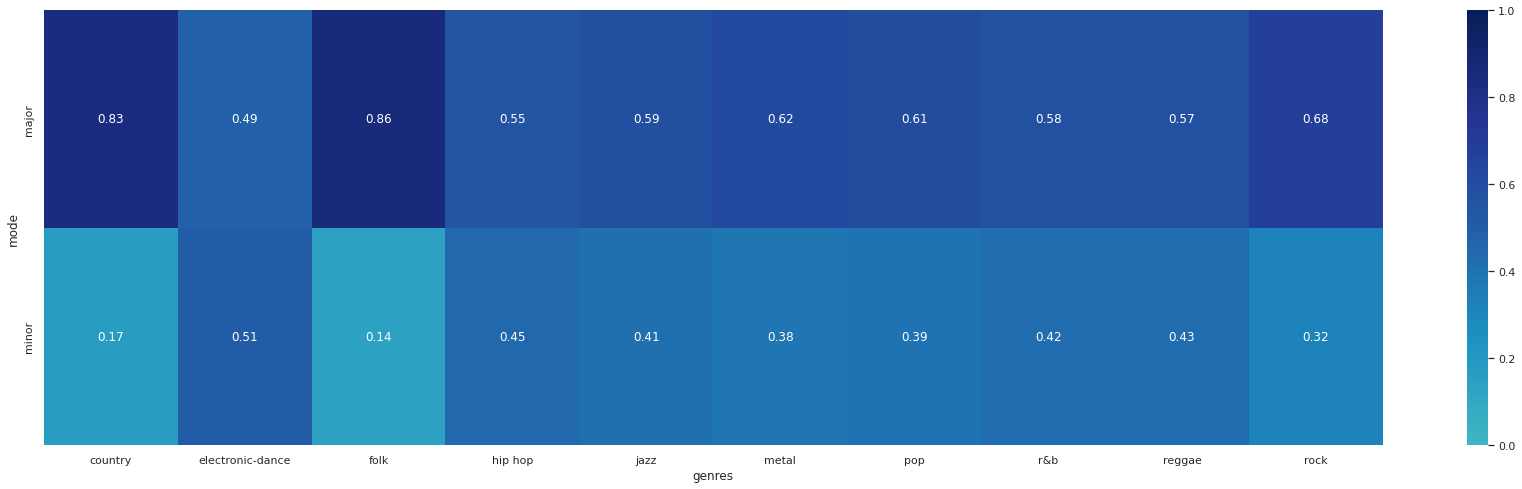

In [182]:
plt.figure(figsize=(30, 8))
# sns.histplot(data=df_with_genre, x="genres", y="mode", cbar=True)
sns.heatmap(table, vmin=0, vmax=1, annot=True, center=0, cmap="YlGnBu")


#### Which combinations of genres appear frequently?

<AxesSubplot:>

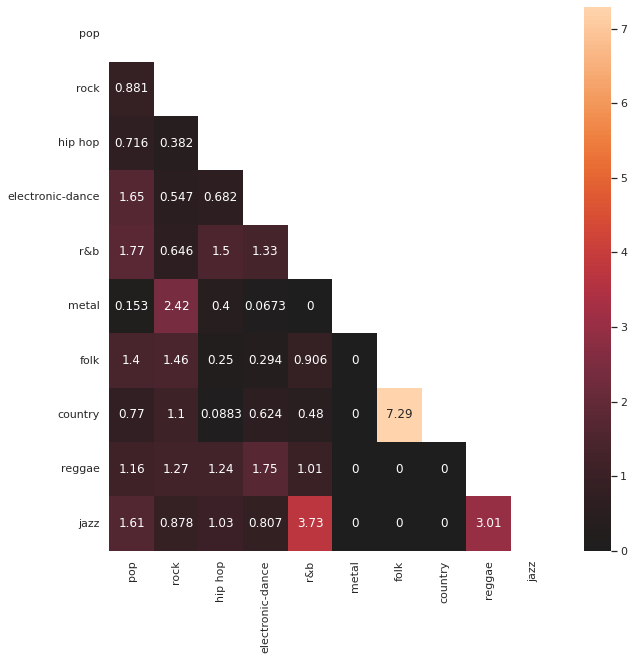

In [184]:
m = ConfusionMatrix(list(df_with_genre["genres"].value_counts().index))
count = df_with_genre["genres"].value_counts()
for genre in count.index:
    m.update_diag(genre, count[genre])

for i, row in df_with_genre.dropna().iterrows():
    if i == 0:
        prev_track = row["track_id"]
        curr_list = [row["genres"]]
        continue
    curr_track = row["track_id"]
    if prev_track != curr_track:
        for pair in findsubsets(curr_list, 2):
            m.increment(pair)
        prev_track = curr_track
        curr_list = [row["genres"]]
    else:
        curr_list.append(row["genres"])
m.normalize()
m.reset_diag()

mask = np.zeros_like(m.matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 10))

sns.heatmap(m.matrix, annot=True, center=0, fmt=".3g", mask=mask,
            xticklabels=m.ele, yticklabels=m.ele)


### Release date analysis
The original data is divided into 7 time periods:
- Before 1980: 225 songs
- 1980s: 177 songs
- 1990s: 222 songs
- 2000s: 521 songs
- From 2010 to 2014: 780 songs
- From 2015 to 2017: 1169 songs
- From 2018 to present: 1366 songs

##### Number of songs released in each 5-year interval

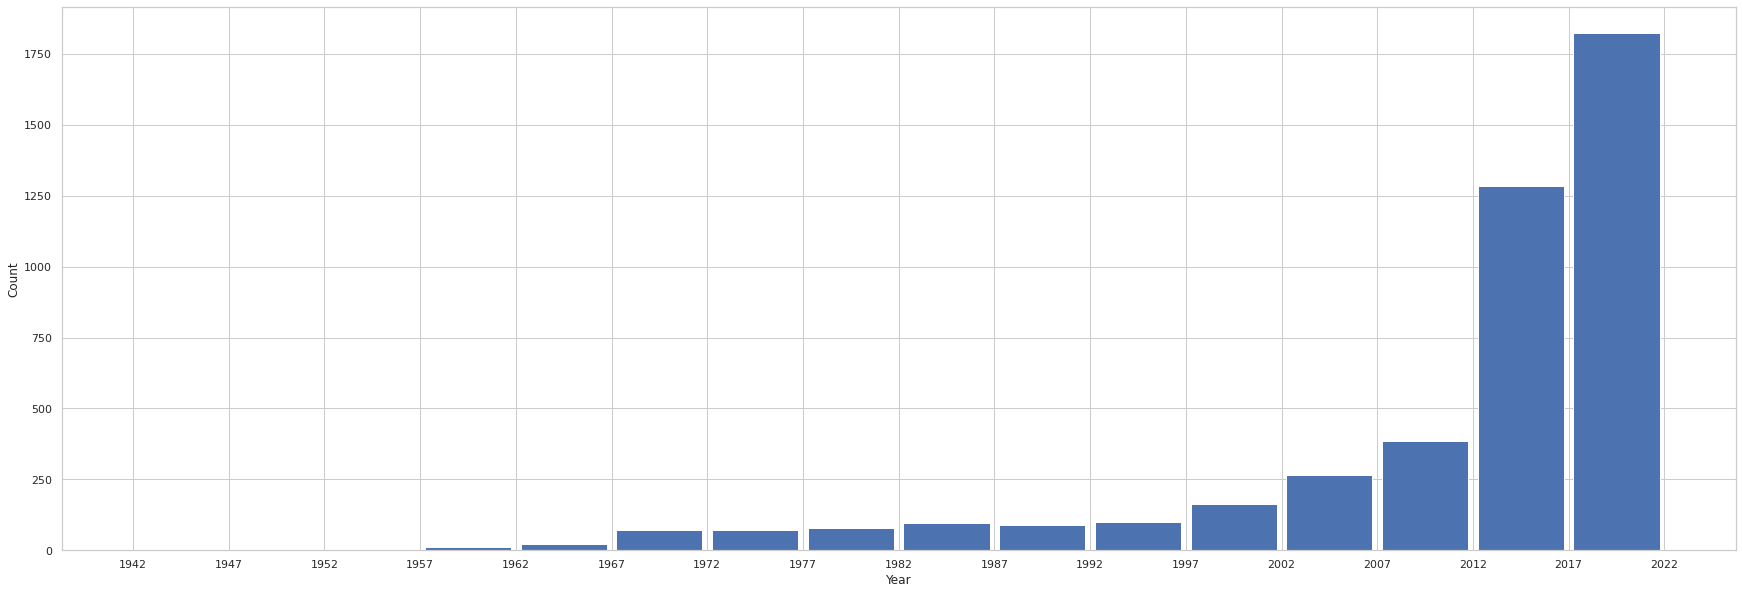

In [185]:
plt.figure(figsize=(30, 10))
data = df["sp_release_date"]
data = [t.year for t in data]
number = np.arange(min(data), max(data) + 5, 5)
label = map(lambda x: str(x), number)
plt.hist(data, bins=number, rwidth=0.9)
plt.xticks(number, label)
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


#### Average view and playcount by year

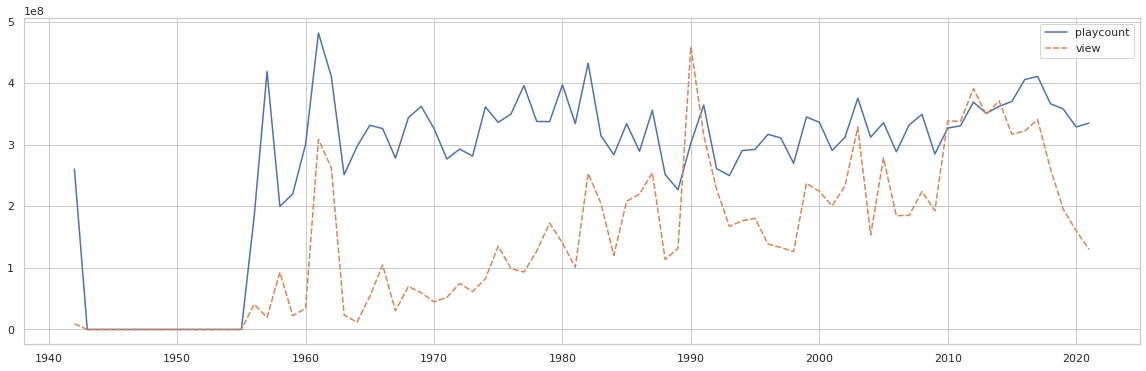

In [186]:
plt.figure(figsize=(20, 6))
plot_popularity_by_year(df)

#### Average view and playcount by time hand-splitted time period

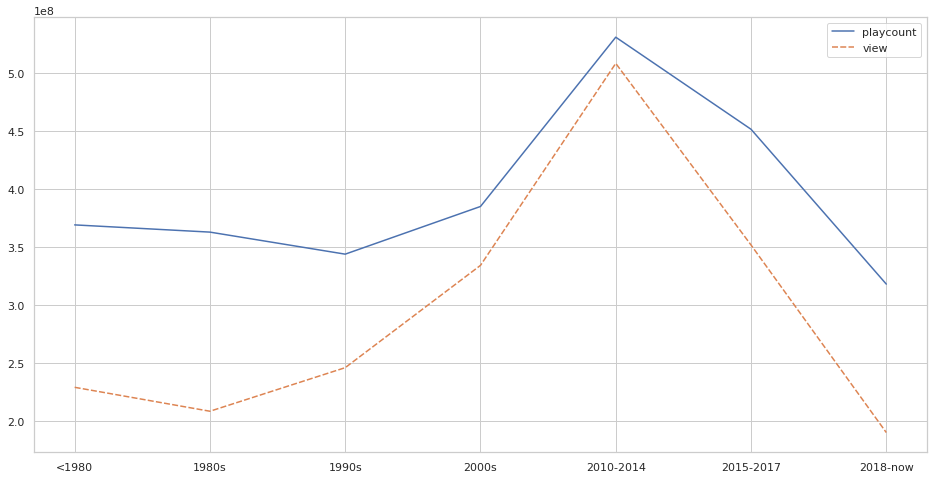

In [187]:
plt.figure(figsize=(16,8))
plot_popularity_by_eras(df_with_genre)

#### Now for each genre

##### By year

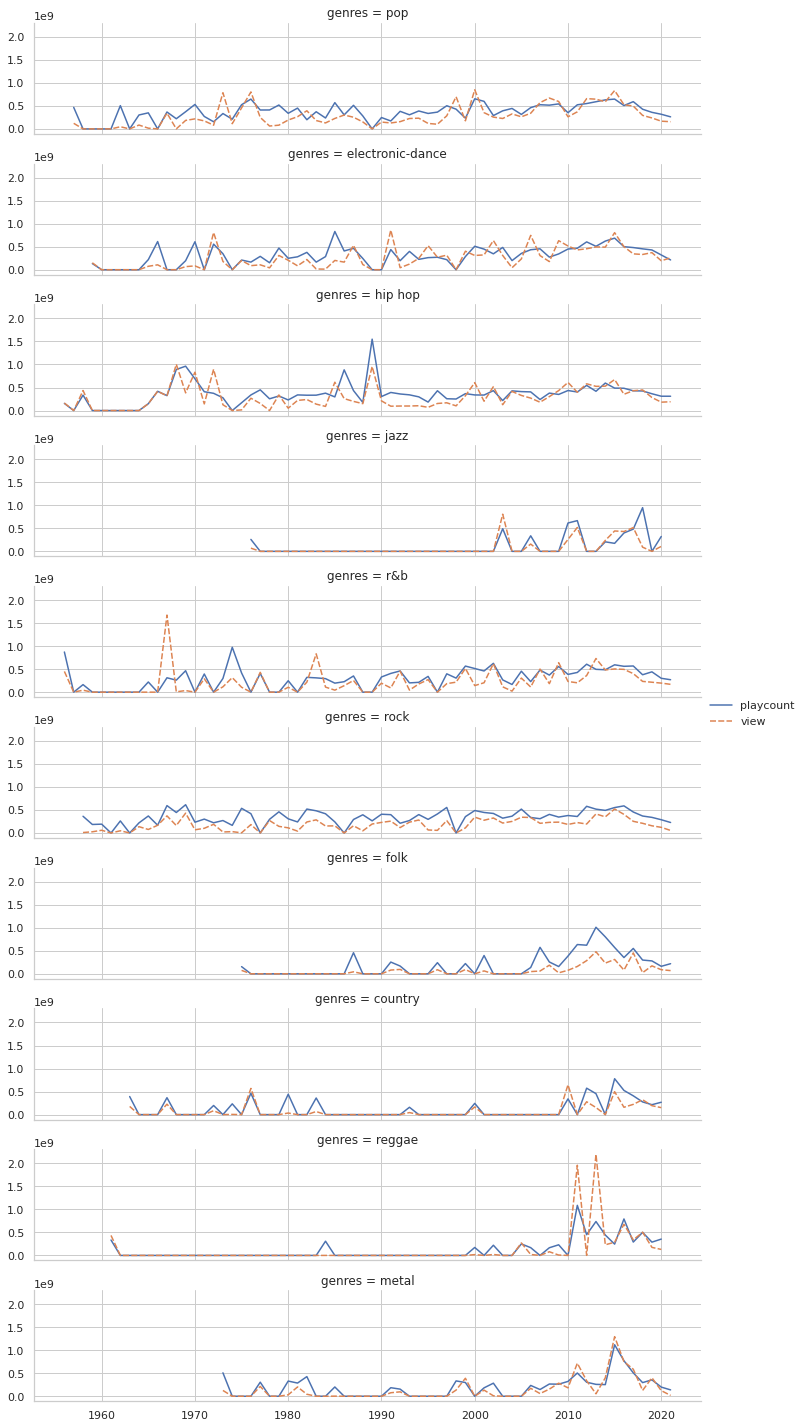

In [188]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
g.map_dataframe(plot_popularity_by_year)
g.add_legend()

##### By time period

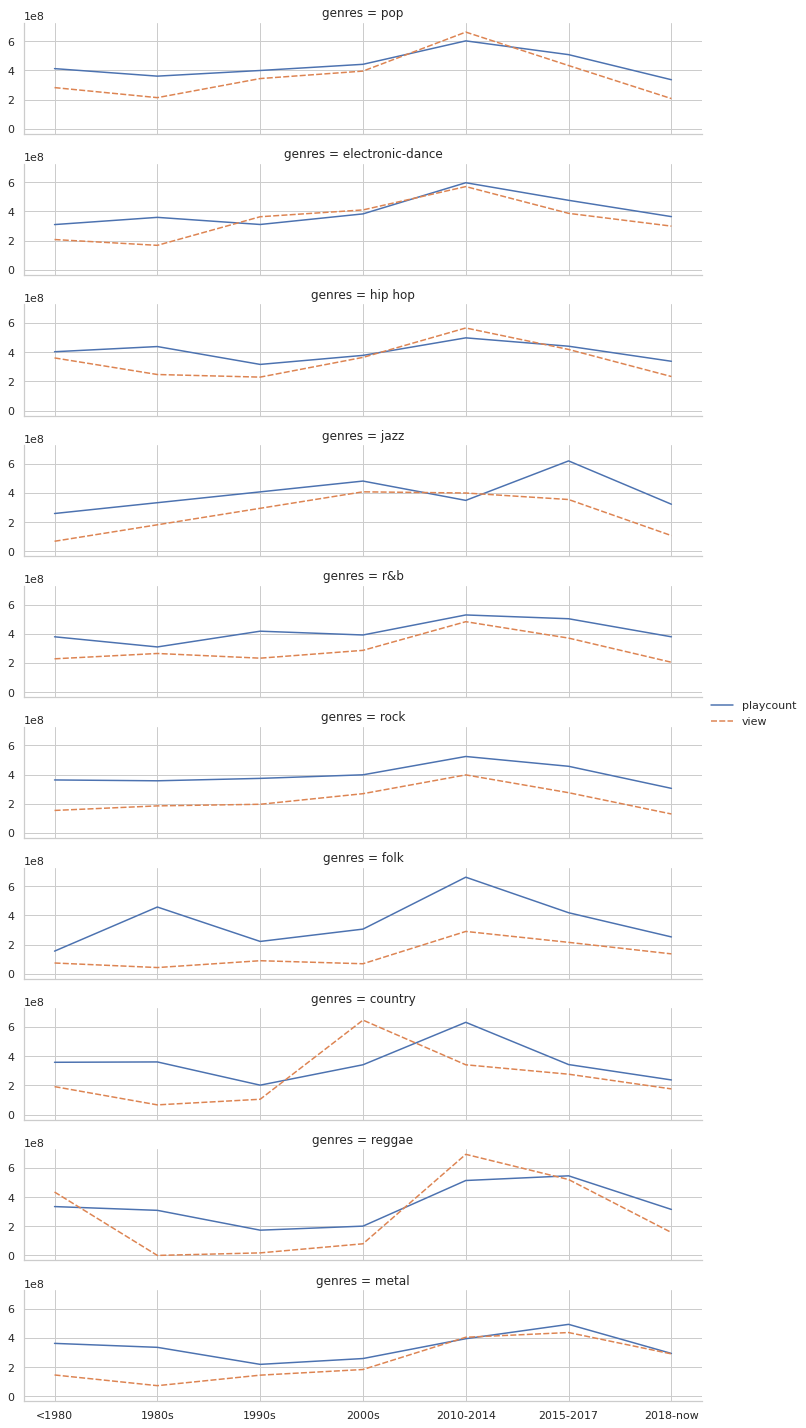

In [189]:
g = sns.FacetGrid(df_with_genre, row="genres", aspect=5, height=2)
g.map_dataframe(plot_popularity_by_eras)
g.add_legend()

### Very popular songs analysis

#### Discretize playcount and view into 2 groups, 0-500mil and >500mil

In [9]:
df_playcount_dis = discretize(df_with_genre, 'playcount', popularity)
df_view_dis = discretize(df_with_genre, 'view', popularity)

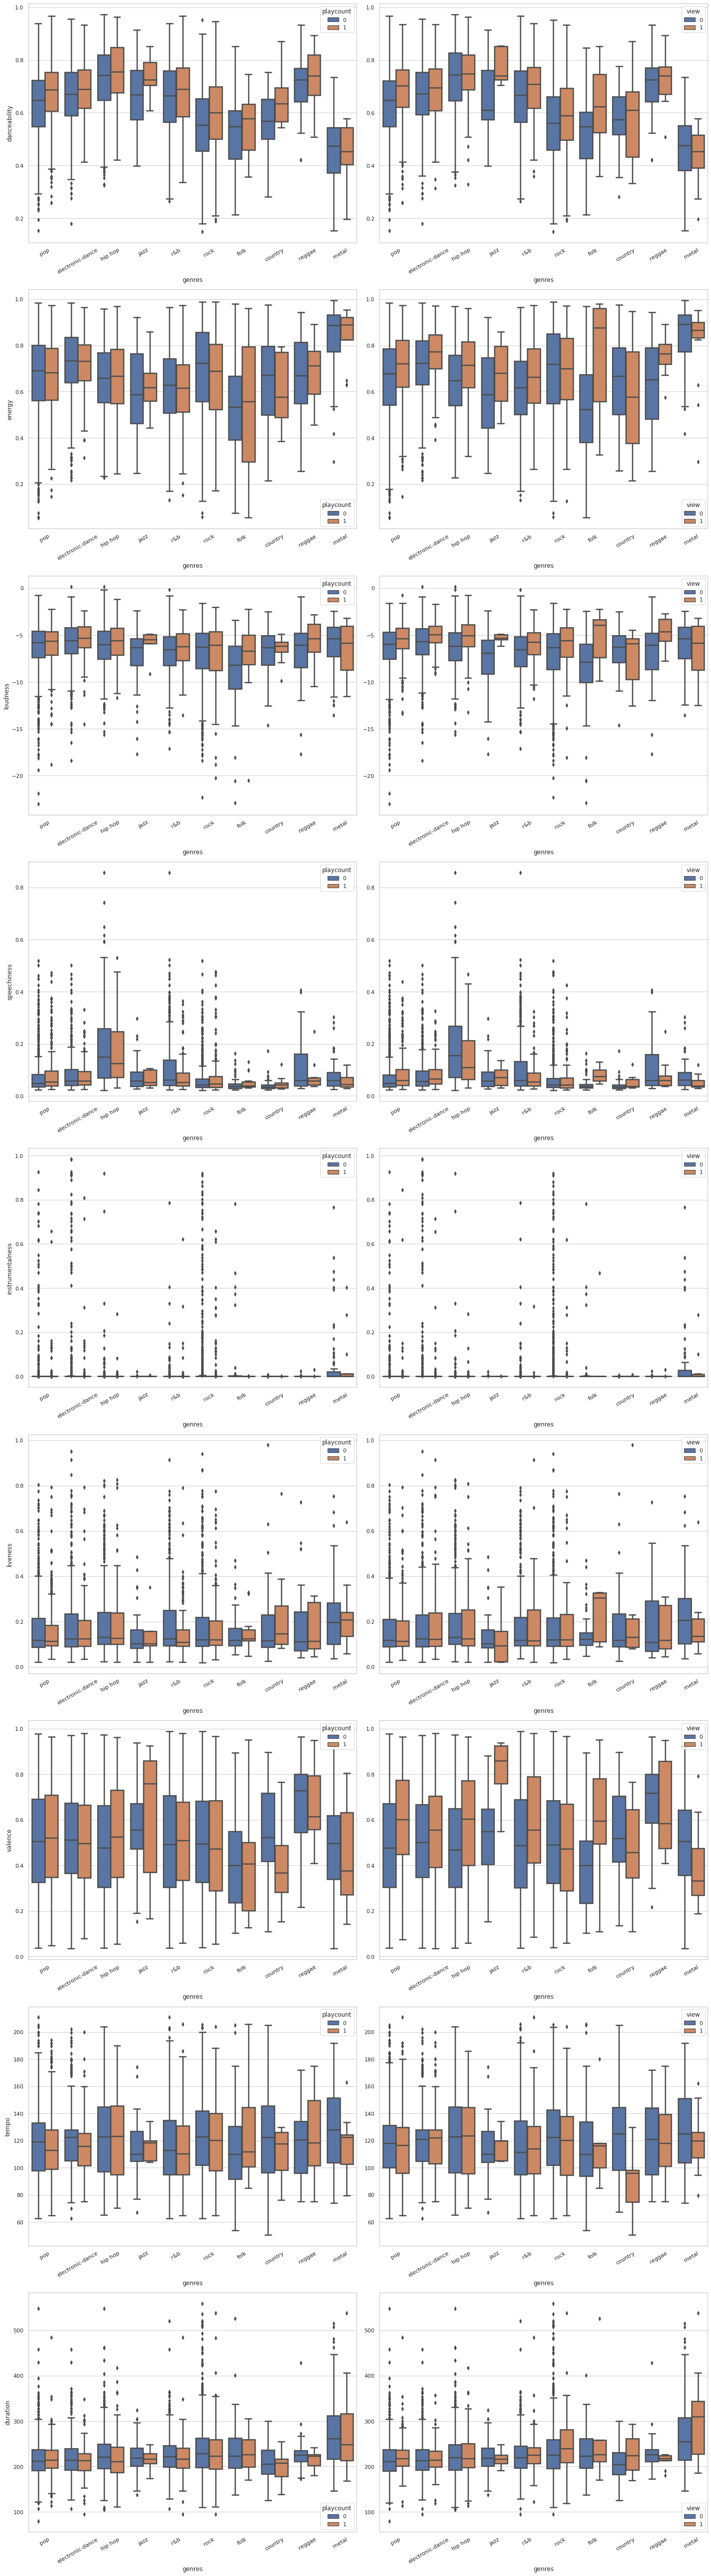

In [23]:
fig, axes = plt.subplots(len(num_feature), 2, figsize=(20, 8 * len(num_feature)))
for i in range(len(num_feature)):
    sns.boxplot(x="genres", y=num_feature[i], hue="playcount",
                    data=df_playcount_dis, linewidth=2.5, ax=axes[i, 0])
    sns.boxplot(x="genres", y=num_feature[i], hue="view",
                    data=df_view_dis, linewidth=2.5, ax=axes[i, 1])
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params('x', labelrotation=30)
    axes[i, 0].tick_params('x', labelrotation=30)
fig.tight_layout()

### Parallel plot (dropped)

In [238]:
df_playcount_split, interval = discretize(df_raw, 'playcount', popularity, return_interval=True)
print(interval)
df_playcount_split['playcount'].unique()

IntervalIndex([(0.0, 500000000.0], (500000000.0, inf]],
              closed='right',
              dtype='interval[float64]')


[1, 0]
Categories (2, int64): [0 < 1]

In [241]:
fig = go.Figure(data=
    go.Parcoords(
        # line = dict(color = df_playcount_split['mode'],
        #            colorscale = 'Electric',
        #            showscale = True
        #        #     cmin = -4000,
        #        #     cmax = -100
        #            ),
        dimensions = list([
             dict(values = df_playcount_split["loudness"]
             ),
            dict(tickvals = [0, 1],
                values = df_playcount_split['playcount'])])
    )
)
fig.show()

In [ ]:
fig = px.parallel_coordinates(df[['valence', 'tempo', 'danceability', 'energy']], color='energy')
fig.show()

#### Just some code examples

In [208]:
import plotly.graph_objects as go

import pandas as pd

test = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = test['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(
               #   constraintrange = [100000,150000],
                 label = "Block Height", values = test['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = test['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = test['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = test['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = test['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = test['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = test['HstW'])])
    )
)
fig.show()

In [195]:
test = px.data.iris()
fig = px.parallel_coordinates(test, color="species_id", labels={"species_id": "Species",
                "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                "petal_width": "Petal Width", "petal_length": "Petal Length", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2
                             )
fig.show()

#### Utter garbage

In [82]:
import plotly.graph_objects as go
df_view_plit = discretize(df_with_genre, 'view', popularity)
explicit_val = []
genre_val = []
view_val = []
for _, row in df_view_plit.iterrows():
    explicit_val.append(row['explicit'])
    genre_val.append(row['genres'])
    view_val.append(row['view'])
fig = go.Figure(go.Parcats(
    dimensions=[
        {'label': 'Explicit',
         'values': explicit_val},
        {'label': 'Genres',
         'values': genre_val},
        {'label': 'View',
         'values': view_val}]
))

fig.show()

### Sankey diagram (dropped)

In [100]:
import random
color_test = [f'hsl({c[0]:.0%},{c[1]:.0%},{c[2]:.0%})' for c in sns.color_palette(palette='hls', n_colors=len(data['data'][0]['node']['color']))]
random.shuffle(color_test)

In [110]:
df.values

array([['Shape of You', '0FE9t6xYkqWXU2ahLh6D8X', 'Ed Sheeran', ...,
        'Ed Sheeran', '2017-01-30T10:57:50Z',
        'Ed Sheeran - Shape of You (Official Music Video)'],
       ['Blinding Lights', '0sf12qNH5qcw8qpgymFOqD', 'The Weeknd', ...,
        'TheWeekndVEVO', '2019-11-29T05:00:08Z',
        'The Weeknd - Blinding Lights (Official Audio)'],
       ['Dance Monkey', '5ZULALImTm80tzUbYQYM9d', 'Tones And I', ...,
        'Tones And I', '2019-06-24T22:01:36Z',
        'TONES AND I - DANCE MONKEY (OFFICIAL VIDEO)'],
       ...,
       ["I Love You's", '60todhJq1ScRkVxFvXTuZF', 'Hailee Steinfeld',
        ..., 'HaileeSteinfeldVEVO', '2020-03-31T20:00:09Z',
        'Hailee Steinfeld - I Love You&#39;s (Official Video)'],
       ['Girls Like Us', '5SFXOMJJ334Wn2PwBHeRZN', 'Zoe Wees', ...,
        'ZoeWeesVEVO', '2021-01-14T17:00:11Z',
        'Zoe Wees - Girls Like Us'],
       ['m y . l i f e (with 21 Savage & Morray)',
        '1D3z6HTiQsNmZxjl7F7eoG', 'J. Cole', ..., 'J. Cole',
 

In [ ]:
all_nodes = european_countries_migration.Country.values.tolist() + european_countries_migration.Measure.values.tolist()
source_indices = [all_nodes.index(country) for country in european_countries_migration.Country]
target_indices = [all_nodes.index(measure) for measure in european_countries_migration.Measure]

colors = pex.colors.qualitative.D3

node_colors_mappings = dict([(node,np.random.choice(colors)) for node in all_nodes])
node_colors = [node_colors_mappings[node] for node in all_nodes]
edge_colors = [node_colors_mappings[node] for node in european_countries_migration.Country]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "black", width = 1.0),
      label =  all_nodes,
      color =  node_colors,
    ),

    link = dict(
      source =  source_indices,
      target =  target_indices,
      value =  european_countries_migration.Value,
      color = edge_colors,
))])

fig.update_layout(title_text="Population Migration between New Zealand and European Countries",
                  height=600,
                  font_size=10)
fig.show()

### Miscellaneous

In [106]:
sns.color_palette(palette='hls', n_colors=len(data['data'][0]['node']['color']))

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.4362, 0.33999999999999997),
 (0.86, 0.5012, 0.33999999999999997),
 (0.86, 0.5661999999999999, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.86, 0.6961999999999999, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.86, 0.8261999999999999, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.7638, 0.86, 0.33999999999999997),
 (0.6988, 0.86, 0.33999999999999997),
 (0.6337999999999998, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.5038, 0.86, 0.33999999999999997),
 (0.43879999999999986, 0.86, 0.33999999999999997),
 (0.3738000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.4361999999999999),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.86, 0.5662),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.86, 0.6962000000000002),
 (0.33999999999999997, 0.86, 0.7612000000000001),
 (0.33999999999999997, 0.86, 0.8261999999999999),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.7638, 0.86),
 (0.33999999999999997, 0.6988, 0.86),
 (0.33999999999999997, 0.6337999999999998, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.33999999999999997, 0.5038, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.33999999999999997, 0.3738000000000001, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.43619999999999975, 0.33999999999999997, 0.86),
 (0.5011999999999995, 0.33999999999999997, 0.86),
 (0.5662, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.6961999999999995, 0.33999999999999997, 0.86),
 (0.7612000000000001, 0.33999999999999997, 0.86),
 (0.8261999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.7638),
 (0.86, 0.33999999999999997, 0.6987999999999996),
 (0.86, 0.33999999999999997, 0.6337999999999998),
 (0.86, 0.33999999999999997, 0.5688000000000001),
 (0.86, 0.33999999999999997, 0.5037999999999996),
 (0.86, 0.33999999999999997, 0.43879999999999986),
 (0.86, 0.33999999999999997, 0.3738000000000001)]

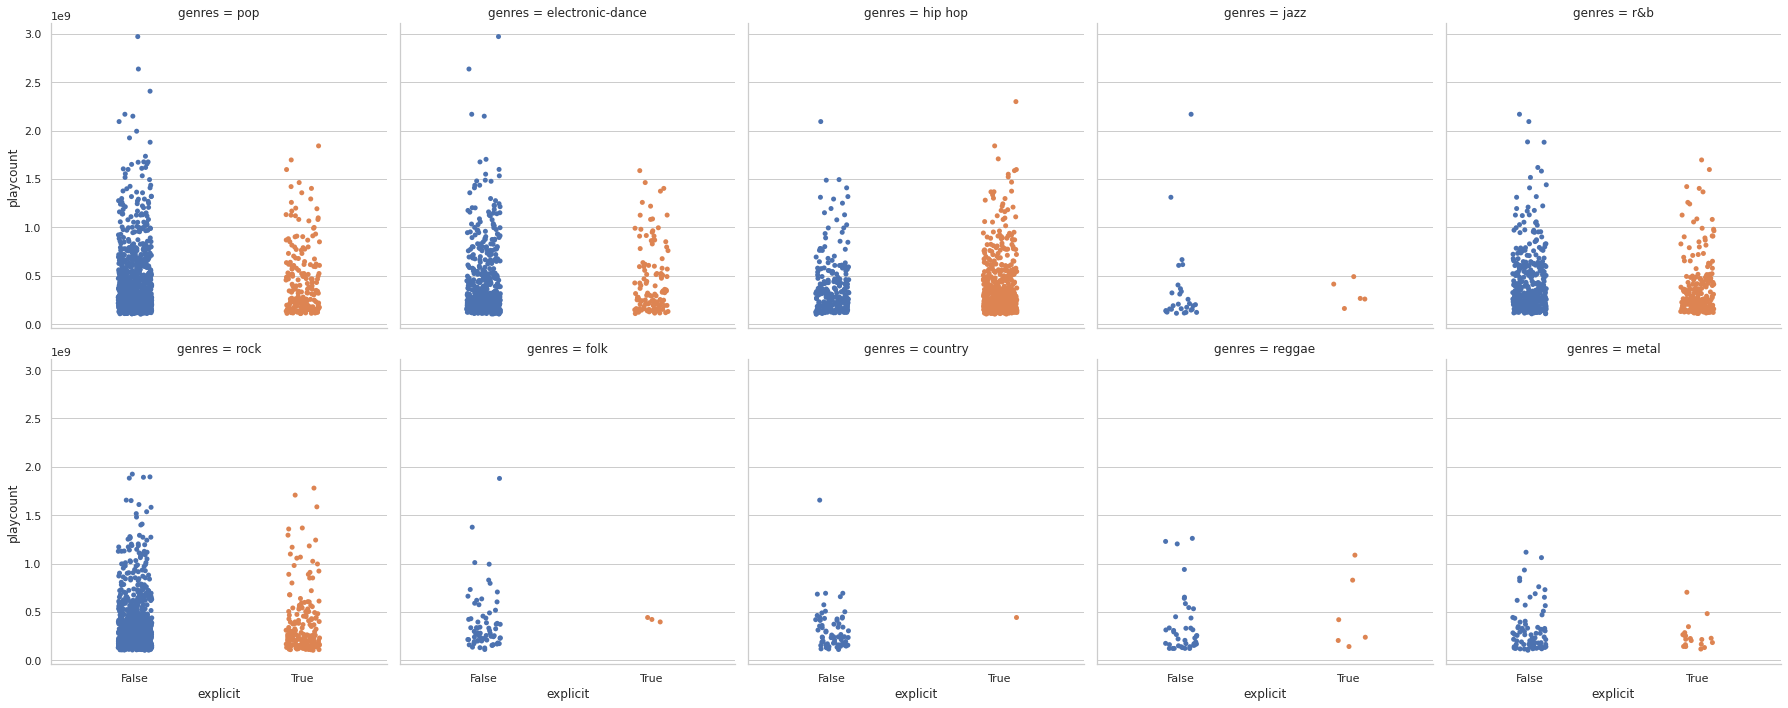

In [ ]:
sns.catplot(x="explicit", y="playcount",
            col="mode", data=df_with_genre, col_wrap=5)